# Kinetics with Metadynamics + Mean Force Integration

This work is intended to propose a new approach to the study of chemical reactions, especially for reactions in liquid phase (bulk or solution). This approach is based on molecular dynamics with QM/MM potentials, where the QM part is described by the **GFN1 xTB** [ref.] hamiltonian, whereas the MM part is treated with the **GAFF** force field. The methodology is firstly appied to study the beta-scission and intramolecular H-transfer (backbiting) of Poly-Butyl Acrylate (PBA) for which experimental data for validation is largely available. The calculations have been performed on model oligomers (dimer and trimer) of nButyl Acrylate.

This notebook is organized as follows:

1. **beta-scission of PBA dimer**

     I) Gas phase
        
        a) T = 310 K
        b) T = 410 K
        c) T = 510 K
    
     II) Bulk (nButyl Acrylate monomer) 

        T = 410 K
        
    III) Xylene Solvent

        T = 410 K

     IV) Water Solvent

        a) T = 310 K
        b) T = 410 K
        c) T = 510 K
        
2. **Intramolecular H-Transfer**

     I) Gas phase
        
        a) T = 310 K
        b) T = 410 K
        
    III) Xylene Solvent

        a) T = 310 K
        b) T = 410 K
        
     II) Water solvent

        a) T = 310 K
        b) T = 410 K
              

### Workflow

Here is a summary of the workflow followed

**I)** Integration of multiple independent metadynamics simulations into a single free energy surface by means of the MeanForce Integration algorithm.

**II)** Find the Minimum Free Energy Pathway with the Climbing Image Nudged Elastic Band method (custom implementation in Libraries/MEP.py).

**III)** Perform the Histogram Test for TS validation

**IV)** Compute rate parameters based on the Generalized Transition State Theory for Rare Events.

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import json
import codecs
os.chdir("C:/Users/fserse/Desktop/PhD_Thesis/Kinetics from Metadynamics/")
path = "C:/Users/fserse/Desktop/PhD_Thesis/Kinetics from Metadynamics/"

In [4]:
cwd = os.getcwd()
print(cwd)

C:\Users\fserse\Desktop\PhD_Thesis\Kinetics from Metadynamics


In [5]:
pckg_path = (r"C:/Users/fserse/Desktop/PhD_Thesis/Kinetics from Metadynamics/Libraries")

The function **metadyn2hills()** converts the .metadynlog of cp2k to a PLUMED hills file

In [6]:
def metadyn2hills(sigma_x,sigma_y,gamma,hartree2_kj, nsim_start, nsim_end, path, hills_stride):

     for i in np.arange(nsim_start,nsim_end+1):
            
        with open(str(path)+"colvar_"+str(i)) as f:
             columns = [str(s.strip()).split() for s in f.readlines()]
        
        f.close()
        
        with open(str(path)+"position_"+str(i),'w') as f:
             for x in columns:
                    f.write("\t{0}\t\t{1}\t\t{2}\n".format(x[0],x[1],x[2]))
        
        f.close()
        
        k = 0
        with open(str(path)+"HILLS_"+str(i),'w') as f:
             for x in columns:
                    if k%(hills_stride/10) == 0:
                        f.write("\t{0}\t{1}\t\t{2} "" {3} "" {4}\t\t{5}\t\t{6}\n".format(x[0],float(x[1]),float(x[2]),sigma_x,sigma_y, 0.00159*hartree_2_kj ,gamma ))
                    k = k+1
        f.close()
      



In [7]:
#input constants
sigma_x = 0.2
sigma_y = 0.2
gamma = -1.0
hartree_2_kj = 627.509*4.18
Bohr2meters = 5.2918e-11

In [8]:
import os
import scienceplots
os.environ["PATH"] += os.pathsep + r'C:\Users\fserse\AppData\Local\Programs\MiKTeX\miktex\bin\x64'
plt.style.use(['science','nature'])

### Import Mean Force Integration package

Veselina Marinova, Matteo Salvalaglio; Time-independent free energies from metadynamics via mean force integration. J. Chem. Phys. 28 October 2019; 151 (16): 164115. https://doi.org/10.1063/1.5123498

In [9]:
#!pip install -e git+https://github.com/mme-ucl/MFI.git#egg=pyMFI

In [10]:
import sys
sys.path.append(str(pckg_path)+'/src/pymfi/')
from pyMFI import MFI

In [11]:
import sys
sys.path.append(str(pckg_path)+'/src/pymfi/')
from pyMFI import MFI1D

### 1. beta-scission of poly-Butyl Acrylate dimer

**I)** Gas phase: Free Energy Surface @310K with GNFN1 xTB

In [25]:
fes_310K_gas_xtb_patch = str(path)+'Simulation Data/nButylAcrylate/BETASC/GAS/310K/'

forces_all = []
master = []
all_hills= []
error_history = []
Ftot_master = []
master_patch = [[np.zeros((400,800)), np.zeros((400,800)), np.zeros((400,800)), np.zeros((400,800)), np.zeros((400,800)), np.zeros((250,800))]]
FP = np.zeros((400,800))
ofe_history_patch = [0]
ofe_history_patch_time = [0]
X = np.linspace(0, 4*np.pi, 800)
Y = np.linspace(-np.pi, np.pi, 400)
time_history_patch = []
volume_history_patch = []
error_history =[]

dx = np.abs( X[0] - X[1] )
dy = np.abs( Y[0] - Y[1] )

In [10]:
#metadyn2hills(sigma_x,sigma_y,gamma,hartree_2_kj, 1, 10, fes_310K_gas_xtb_patch,60)

|**************************************************| 100% | Bootstrap Average Standard Deviation: 1.946

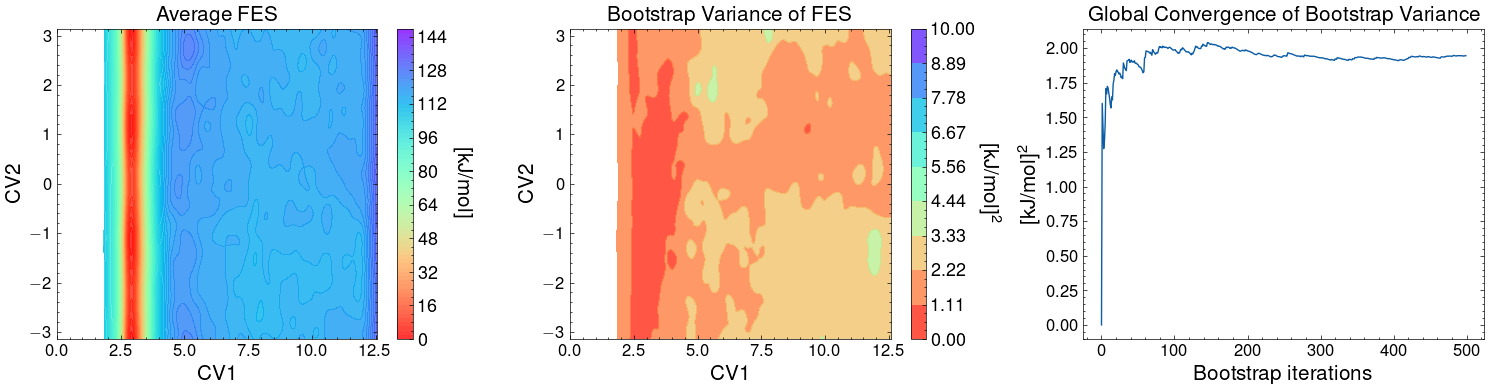

In [26]:
n_simulations = 10

for simulation in np.arange(1,n_simulations+1):

    HILLS=MFI.load_HILLS_2D(hills_name=str(fes_310K_gas_xtb_patch)+"HILLS_"+str(simulation))
    #plt.plot(HILLS[:,1],HILLS[:,2],'.')
    #Read the Colvar File
    [position_x, position_y] = MFI.load_position_2D(position_name=str(fes_310K_gas_xtb_patch)+"position_"+str(simulation))
    #COMPUTE Mean force and weight of the simulation
    [X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, time_history, Ftot_den2, ofv_num_x, ofv_num_y] = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw_x = 0.2, bw_y = 0.2, kT = 2.58, min_grid = np.array((0, -np.pi)), max_grid = np.array((4*np.pi, np.pi)), nbins = np.array((400,800)), log_pace = 100, error_pace = 100, base_terms=0, window_corners=[], WellTempered = 0, nhills=-1, periodic_x=0, periodic_y=1, FES_cutoff=150)

    forces_all.append([X, Y, Ftot_den, Ftot_x, Ftot_y])

    master.append([Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_y])

    master_patch.append(MFI.patch_2D(master))
    
    ofe_history_patch += ofe_history
    ofe_history_time_adj = [element+ofe_history_patch_time[-1] for element in time_history]
    ofe_history_patch_time += ofe_history_time_adj
    
    volume_history_patch.append(volume_history)
    error_history.append(ofe_history)
    time_history_patch.append(time_history)

######### Monitor Mean Force Error ##############

############## Bootstrap ##############

forces_all_ = np.asarray(forces_all)[:,[2,3,4],:,:]

[FES_avr_gas_2d, sd_fes_gas_2d, sd_fes_prog_gas_2d ] = MFI.bootstrap_2D_new(X, Y, forces_all_, n_bootstrap=500, FES_cutoff=150)

MFI.plot_bootstrap(X, Y, MFI.zero_to_nan(np.where(master_patch[-1][0] > 0.1, FES_avr_gas_2d, 0)), MFI.zero_to_nan(np.where(master_patch[-1][0] > 0.1 , sd_fes_gas_2d, 0)), sd_fes_prog_gas_2d, FES_lim=150, ofe_lim=10)
plt.tight_layout()
plt.savefig("free_energy_surf_betasc_310K.png", format="png", dpi=1200)
plt.show()

In [27]:
import importlib
importlib.reload(MFI)
X = np.linspace(0, 4*np.pi, 800)
Y = np.linspace(-np.pi, np.pi, 400)
[FES_avr_gas, cutoff, sd_fes_gas, sd_fes_prog_gas ] = MFI.bootstrap_1D_fes(X, Y, forces_all_, n_bootstrap=500, FES_cutoff=150, FFT_integration=1, min_grid=np.array((0, -np.pi)), max_grid=np.array((4*np.pi, np.pi)) )

100 FES st. dev. = 2.077
200 FES st. dev. = 2.35
300 FES st. dev. = 2.352
400 FES st. dev. = 2.282
500 FES st. dev. = 2.307


In [28]:
stdtosave = sd_fes_gas.tolist()
sdjson = json.dump(stdtosave, codecs.open(str(fes_310K_gas_xtb_patch)+'std_gas_310_1d.json','w', encoding = 'utf-8'))

fesavgtosave = FES_avr_gas.tolist()
fes_avgjson = json.dump(fesavgtosave, codecs.open(str(fes_310K_gas_xtb_patch)+'fesavg_gas_310_1d.json','w', encoding = 'utf-8'))

#sdprogtosave = sd_fes_prog_gas.tolist()
sdprogjson = json.dump(sd_fes_prog_gas, codecs.open(str(fes_310K_gas_xtb_patch)+'sdprog_gas_310_1d.json','w', encoding = 'utf-8'))

In [29]:
f = open(str(fes_310K_gas_xtb_patch)+'fesavg_gas_310_1d.json','r')
fes_gas_1d = np.array(json.load(f)).reshape(800)

var = open(str(fes_310K_gas_xtb_patch)+'std_gas_310_1d.json','r') 
sd_gas_1d = np.array(json.load(var)).reshape(800)

sdprog = open(str(fes_310K_gas_xtb_patch)+'sdprog_gas_310_1d.json','r')
sdprog_gas_1d = np.array(json.load(sdprog))

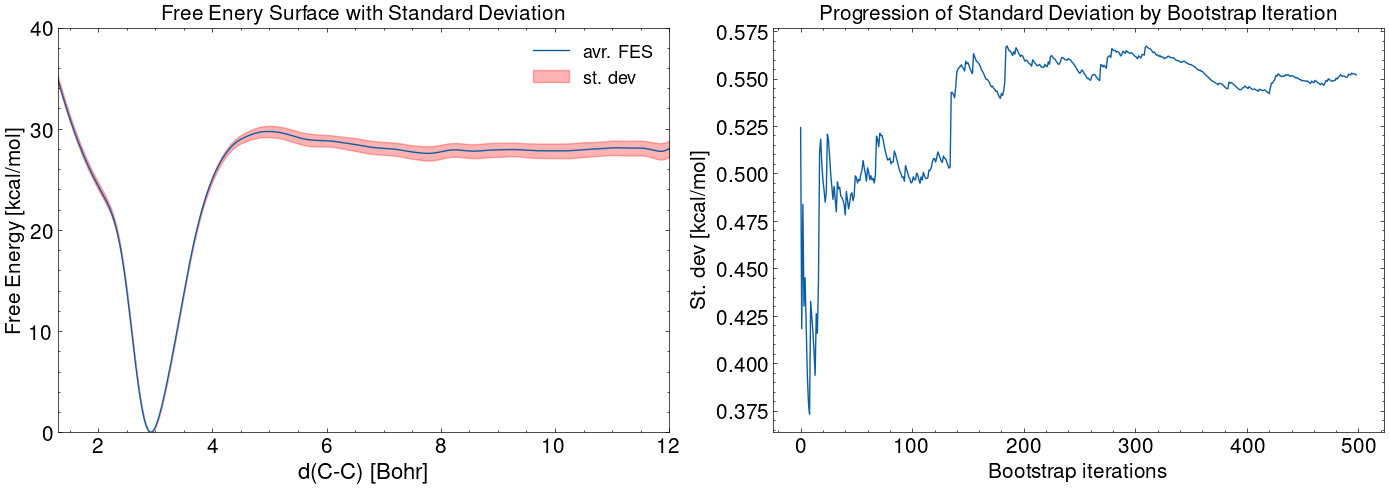

In [30]:
#Plot
plt.figure(figsize=(14,5)); plt.subplot(1,2,1)
plt.plot(X,(FES_avr_gas-np.min(FES_avr_gas)-8)/4.18, label="avr. FES")
plt.fill_between(X, (FES_avr_gas - sd_fes_gas - np.min(FES_avr_gas)-8)/4.18, (FES_avr_gas + sd_fes_gas - np.min(FES_avr_gas)-8)/4.18, alpha=0.3, color="red", label="st. dev")
plt.xlabel("d(C-C)"), plt.ylabel("Free Energy [kcal/mol]", fontsize=15); plt.legend(fontsize = 13); plt.title("Free Enery Surface with Standard Deviation", fontsize=15)
plt.ylim([0,40])
plt.xlim([1.3,12])
plt.xlabel('d(C-C) [Bohr]', fontsize = 16)
#plt.ylabel('FES projection [kcal/mol]',fontsize = 16)
plt.xticks([2,4,6,8,10,12],["2","4","6","8","10","12"] , fontsize=15)
plt.yticks([0,10,20,30,40], ["0", "10", "20", "30","40"], fontsize=15)

plt.subplot(1,2,2)
plt.plot(range(len(sd_fes_prog_gas)), np.asarray(sd_fes_prog_gas)/4.18)
plt.xlabel("Bootstrap iterations", fontsize=15), plt.ylabel("St. dev [kcal/mol]", fontsize=15); plt.title("Progression of Standard Deviation by Bootstrap Iteration", fontsize=15); 
#plt.ylim([0,40])
#plt.xlim([1.3,12])
plt.xticks([0,100,200,300,400,500],["0", "100", "200", "300","400", "500"] , fontsize=15)
plt.yticks(fontsize=15)
#plt.legend([ 'vacuum', "Water", "nBA monomer", "Xylene" ], fontsize = 13)
plt.tight_layout()
plt.savefig("free_energy_surf_1d_betasc_gas_310K.png", format="png", dpi=1200)

## **II)** Gas phase: Free Energy Surface @410K with GNFN1 xTB

In [10]:
fes_410K_gas_xtb_patch = str(path)+'Simulation Data/nButylAcrylate/BETASC/GAS/410K/'

forces_all = []
master = []
all_hills= []
error_history = []
Ftot_master = []
master_patch = [[np.zeros((400,800)), np.zeros((400,800)), np.zeros((400,800)), np.zeros((400,800)), np.zeros((400,800)), np.zeros((250,800))]]
FP = np.zeros((400,800))
ofe_history_patch = [0]
ofe_history_patch_time = [0]
X = np.linspace(0, 4*np.pi, 800)
Y = np.linspace(-np.pi, np.pi, 400)
time_history_patch = []
volume_history_patch = []
error_history =[]

dx = np.abs( X[0] - X[1] )
dy = np.abs( Y[0] - Y[1] )

In [32]:
#metadyn2hills(sigma_x,sigma_y,gamma,hartree_2_kj, 3, 4, fes_410K_gas_xtb_patch,60)

|***************************                       | 54% | Average Mean Force Error: nan6189

C:\Users/fserse/Desktop/PhD_Thesis/Kinetics from Metadynamics/Libraries/src/pymfi\pyMFI\MFI.py:500: RuntimeWarning: invalid value encountered in sqrt
  ofe_x = np.sqrt(ofv_x)


|**************************************************| 100% | Bootstrap Average Standard Deviation: 2.133

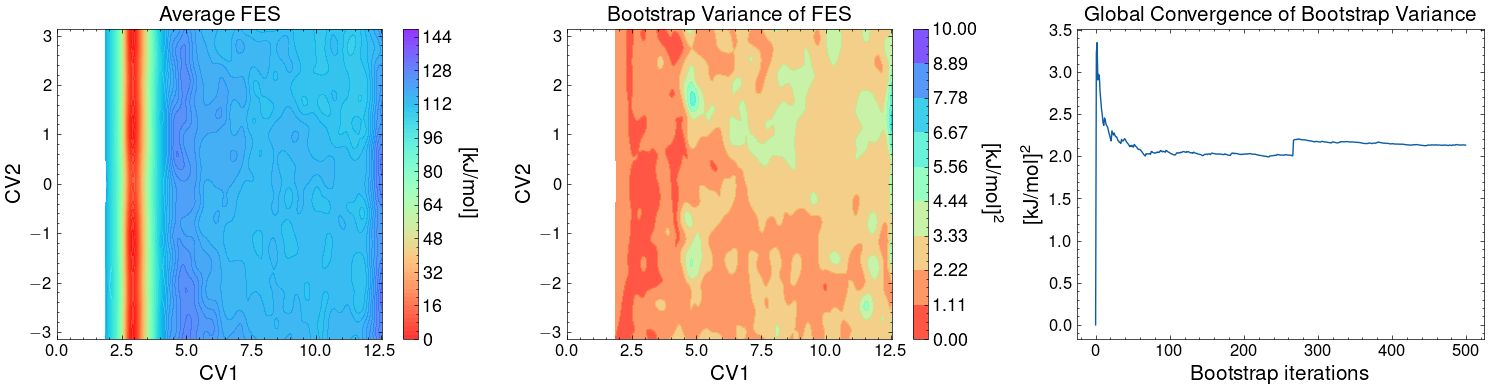

In [11]:
n_simulations = 9

for simulation in np.arange(3,n_simulations+1):

    HILLS=MFI.load_HILLS_2D(hills_name=str(fes_410K_gas_xtb_patch)+"HILLS_"+str(simulation))
    #plt.plot(HILLS[:,1],HILLS[:,2],'.')
    #Read the Colvar File
    [position_x, position_y] = MFI.load_position_2D(position_name=str(fes_410K_gas_xtb_patch)+"position_"+str(simulation))
    #COMPUTE Mean force and weight of the simulation
    [X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, time_history, Ftot_den2, ofv_num_x, ofv_num_y] = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw_x = 0.2, bw_y = 0.2, kT = 3.4, min_grid = np.array((0, -np.pi)), max_grid = np.array((4*np.pi, np.pi)), nbins = np.array((400,800)), log_pace = 100, error_pace = 100, base_terms=0, window_corners=[], WellTempered = 0, nhills=-1, periodic_x=0, periodic_y=1, FES_cutoff=150)

    forces_all.append([X, Y, Ftot_den, Ftot_x, Ftot_y])

    master.append([Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_y])

    master_patch.append(MFI.patch_2D(master))
    
    ofe_history_patch += ofe_history
    ofe_history_time_adj = [element+ofe_history_patch_time[-1] for element in time_history]
    ofe_history_patch_time += ofe_history_time_adj
    
    volume_history_patch.append(volume_history)
    error_history.append(ofe_history)
    time_history_patch.append(time_history)

######### Monitor Mean Force Error ##############

############## Bootstrap ##############

forces_all_ = np.asarray(forces_all)[:,[2,3,4],:,:]

[FES_avr_gas_2d, sd_fes_gas_2d, sd_fes_prog_gas_2d] = MFI.bootstrap_2D_new(X, Y, forces_all_, n_bootstrap=500, FES_cutoff=150)

MFI.plot_bootstrap(X, Y, MFI.zero_to_nan(np.where(master_patch[-1][0] > 0.1, FES_avr_gas_2d, 0)), MFI.zero_to_nan(np.where(master_patch[-1][0] > 0.1 , sd_fes_gas_2d, 0)), sd_fes_prog_gas_2d, FES_lim=150, ofe_lim=10)
plt.tight_layout()
plt.savefig("free_energy_surf_betasc_410K.png", format="png", dpi=1200)
plt.show()

In [12]:
import importlib
importlib.reload(MFI)
X = np.linspace(0, 4*np.pi, 800)
Y = np.linspace(-np.pi, np.pi, 400)
[FES_avr_gas, cutoff, sd_fes_gas, sd_fes_prog_gas ] = MFI.bootstrap_1D_fes(X, Y, forces_all_, n_bootstrap=500, FES_cutoff=150, FFT_integration=1, min_grid=np.array((0, -np.pi)), max_grid=np.array((4*np.pi, np.pi)) )

100 FES st. dev. = 1.827
200 FES st. dev. = 1.788
300 FES st. dev. = 1.738
400 FES st. dev. = 1.778
500 FES st. dev. = 1.797


In [13]:
stdtosave = sd_fes_gas.tolist()
sdjson = json.dump(stdtosave, codecs.open(str(fes_410K_gas_xtb_patch)+'std_gas_410_1d.json','w', encoding = 'utf-8'))

fesavgtosave = FES_avr_gas.tolist()
fes_avgjson = json.dump(fesavgtosave, codecs.open(str(fes_410K_gas_xtb_patch)+'fesavg_gas_410_1d.json','w', encoding = 'utf-8'))

#sdprogtosave = sd_fes_prog_gas.tolist()
sdprogjson = json.dump(sd_fes_prog_gas, codecs.open(str(fes_410K_gas_xtb_patch)+'sdprog_gas_410_1d.json','w', encoding = 'utf-8'))

In [14]:
f = open(str(fes_410K_gas_xtb_patch)+'fesavg_gas_410_1d.json','r')
fes_gas_1d = np.array(json.load(f)).reshape(800)

var = open(str(fes_410K_gas_xtb_patch)+'std_gas_410_1d.json','r') 
sd_gas_1d = np.array(json.load(var)).reshape(800)

sdprog = open(str(fes_410K_gas_xtb_patch)+'sdprog_gas_410_1d.json','r')
sdprog_gas_1d = np.array(json.load(sdprog))

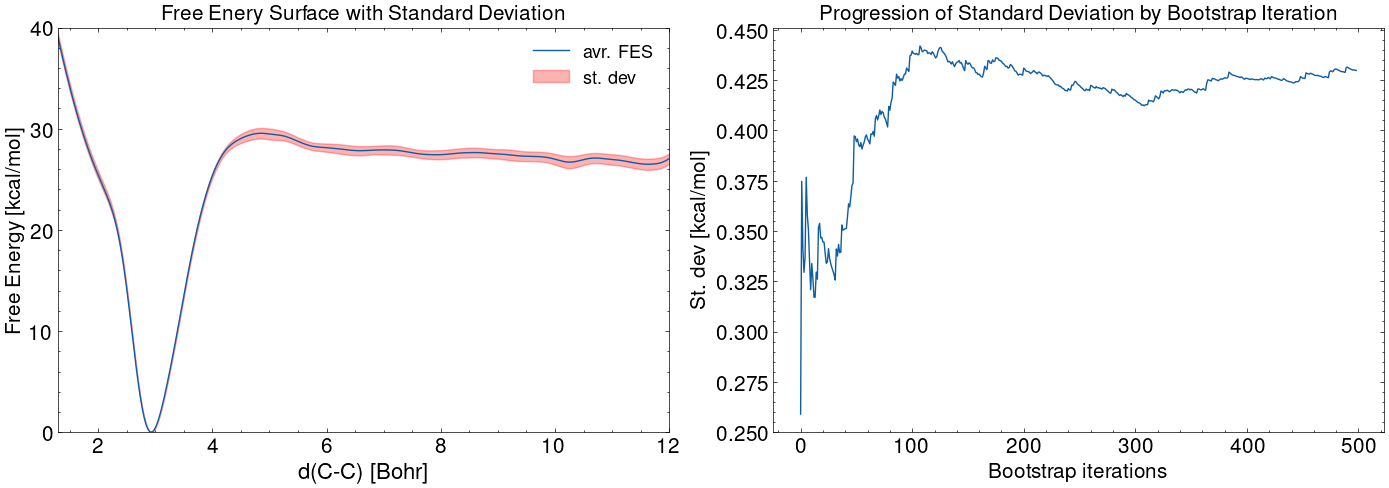

In [15]:
#Plot
plt.figure(figsize=(14,5)); plt.subplot(1,2,1)
plt.plot(X,(FES_avr_gas-np.min(FES_avr_gas)-8)/4.18, label="avr. FES")
plt.fill_between(X, (FES_avr_gas - sd_fes_gas - np.min(FES_avr_gas)-8)/4.18, (FES_avr_gas + sd_fes_gas - np.min(FES_avr_gas)-8)/4.18, alpha=0.3, color="red", label="st. dev")
plt.xlabel("d(C-C)"), plt.ylabel("Free Energy [kcal/mol]", fontsize=15); plt.legend(fontsize = 13); plt.title("Free Enery Surface with Standard Deviation", fontsize=15)
plt.ylim([0,40])
plt.xlim([1.3,12])
plt.xlabel('d(C-C) [Bohr]', fontsize = 16)
#plt.ylabel('FES projection [kcal/mol]',fontsize = 16)
plt.xticks([2,4,6,8,10,12],["2","4","6","8","10","12"] , fontsize=15)
plt.yticks([0,10,20,30,40], ["0", "10", "20", "30","40"], fontsize=15)

plt.subplot(1,2,2)
plt.plot(range(len(sd_fes_prog_gas)), np.asarray(sd_fes_prog_gas)/4.18)
plt.xlabel("Bootstrap iterations", fontsize=15), plt.ylabel("St. dev [kcal/mol]", fontsize=15); plt.title("Progression of Standard Deviation by Bootstrap Iteration", fontsize=15); 
#plt.ylim([0,40])
#plt.xlim([1.3,12])
plt.xticks([0,100,200,300,400,500],["0", "100", "200", "300","400", "500"] , fontsize=15)
plt.yticks(fontsize=15)
#plt.legend([ 'vacuum', "Water", "nBA monomer", "Xylene" ], fontsize = 13)
plt.tight_layout()
plt.savefig("free_energy_surf_1d_betasc_gas_410K.png", format="png", dpi=1200)

## **III)** Gas phase: Free Energy Surface @510K with GNFN1 xTB

In [12]:
fes_510K_gas_xtb_patch = str(path)+'Simulation Data/nButylAcrylate/BETASC/GAS/510K/'

forces_all = []
master = []
all_hills= []
error_history = []
Ftot_master = []
master_patch = [[np.zeros((400,800)), np.zeros((400,800)), np.zeros((400,800)), np.zeros((400,800)), np.zeros((400,800)), np.zeros((250,800))]]
FP = np.zeros((400,800))
ofe_history_patch = [0]
ofe_history_patch_time = [0]
X = np.linspace(0, 4*np.pi, 800)
Y = np.linspace(-np.pi, np.pi, 400)
time_history_patch = []
volume_history_patch = []
error_history =[]
dx = np.abs( X[0] - X[1] )
dy = np.abs( Y[0] - Y[1] )

In [27]:
#metadyn2hills(sigma_x,sigma_y,gamma,hartree_2_kj, 1, 10, fes_510K_gas_xtb_patch,60)

|**************************************************| 100% | Bootstrap Average Standard Deviation: 2.877

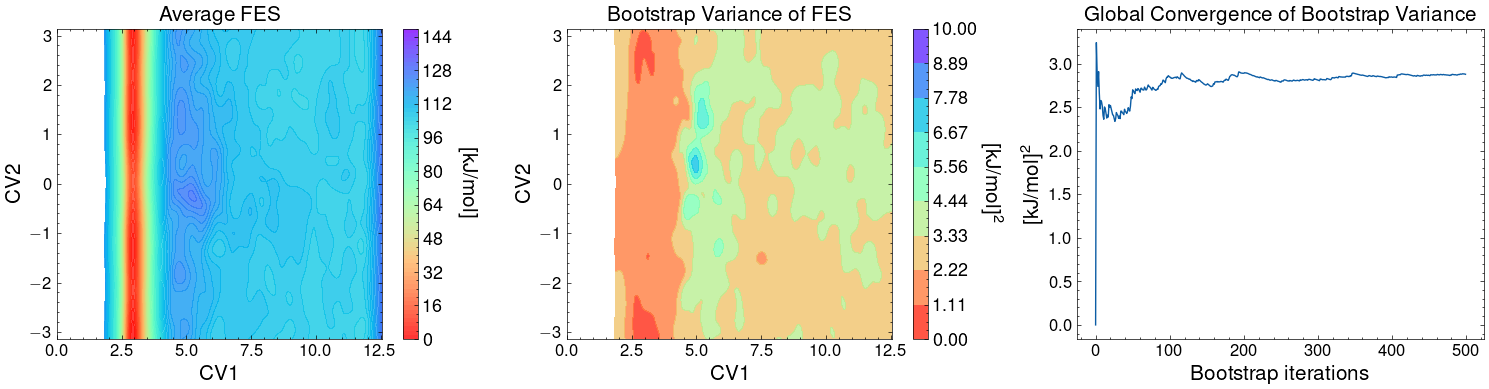

In [42]:
n_simulations = 10

for simulation in np.arange(1,n_simulations+1):

    HILLS=MFI.load_HILLS_2D(hills_name=str(fes_510K_gas_xtb_patch)+"HILLS_"+str(simulation))
    #plt.plot(HILLS[:,1],HILLS[:,2],'.')
    #Read the Colvar File
    [position_x, position_y] = MFI.load_position_2D(position_name=str(fes_510K_gas_xtb_patch)+"position_"+str(simulation))
    #COMPUTE Mean force and weight of the simulation
    [X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, time_history, Ftot_den2, ofv_num_x, ofv_num_y] = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw_x = 0.2, bw_y = 0.2, kT = 4.20, min_grid = np.array((0, -np.pi)), max_grid = np.array((4*np.pi, np.pi)), nbins = np.array((400,800)), log_pace = 100, error_pace = 100, base_terms=0, window_corners=[], WellTempered = 0, nhills=-1, periodic_x=0, periodic_y=1, FES_cutoff=150)

    forces_all.append([X, Y, Ftot_den, Ftot_x, Ftot_y])

    master.append([Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_y])

    master_patch.append(MFI.patch_2D(master))
    
    ofe_history_patch += ofe_history
    ofe_history_time_adj = [element+ofe_history_patch_time[-1] for element in time_history]
    ofe_history_patch_time += ofe_history_time_adj
    
    volume_history_patch.append(volume_history)
    error_history.append(ofe_history)
    time_history_patch.append(time_history)

######### Monitor Mean Force Error ##############

############## Bootstrap ##############

forces_all_ = np.asarray(forces_all)[:,[2,3,4],:,:]

[FES_avr_gas_2d, sd_fes_gas_2d, sd_fes_prog_gas_2d ] = MFI.bootstrap_2D_new(X, Y, forces_all_, n_bootstrap=500, FES_cutoff=150)

MFI.plot_bootstrap(X, Y, MFI.zero_to_nan(np.where(master_patch[-1][0] > 0.1, FES_avr_gas_2d, 0)), MFI.zero_to_nan(np.where(master_patch[-1][0] > 0.1 , sd_fes_gas_2d, 0)), sd_fes_prog_gas_2d, FES_lim=150, ofe_lim=10)
plt.tight_layout()
plt.savefig("free_energy_surf_betasc_510K.png", format="png", dpi=1200)
plt.show()

In [43]:
import importlib
importlib.reload(MFI)
X = np.linspace(0, 4*np.pi, 800)
Y = np.linspace(-np.pi, np.pi, 400)
[FES_avr_gas, cutoff, sd_fes_gas, sd_fes_prog_gas ] = MFI.bootstrap_1D_fes(X, Y, forces_all_, n_bootstrap=500, FES_cutoff=150, FFT_integration=1, min_grid=np.array((0, -np.pi)), max_grid=np.array((4*np.pi, np.pi)) )

100 FES st. dev. = 2.048
200 FES st. dev. = 2.059
300 FES st. dev. = 2.104
400 FES st. dev. = 2.123
500 FES st. dev. = 2.11


In [44]:
stdtosave = sd_fes_gas.tolist()
sdjson = json.dump(stdtosave, codecs.open(str(fes_510K_gas_xtb_patch)+'std_gas_510_1d.json','w', encoding = 'utf-8'))

fesavgtosave = FES_avr_gas.tolist()
fes_avgjson = json.dump(fesavgtosave, codecs.open(str(fes_510K_gas_xtb_patch)+'fesavg_gas_510_1d.json','w', encoding = 'utf-8'))

#sdprogtosave = sd_fes_prog_gas.tolist()
sdprogjson = json.dump(sd_fes_prog_gas, codecs.open(str(fes_510K_gas_xtb_patch)+'sdprog_gas_510_1d.json','w', encoding = 'utf-8'))

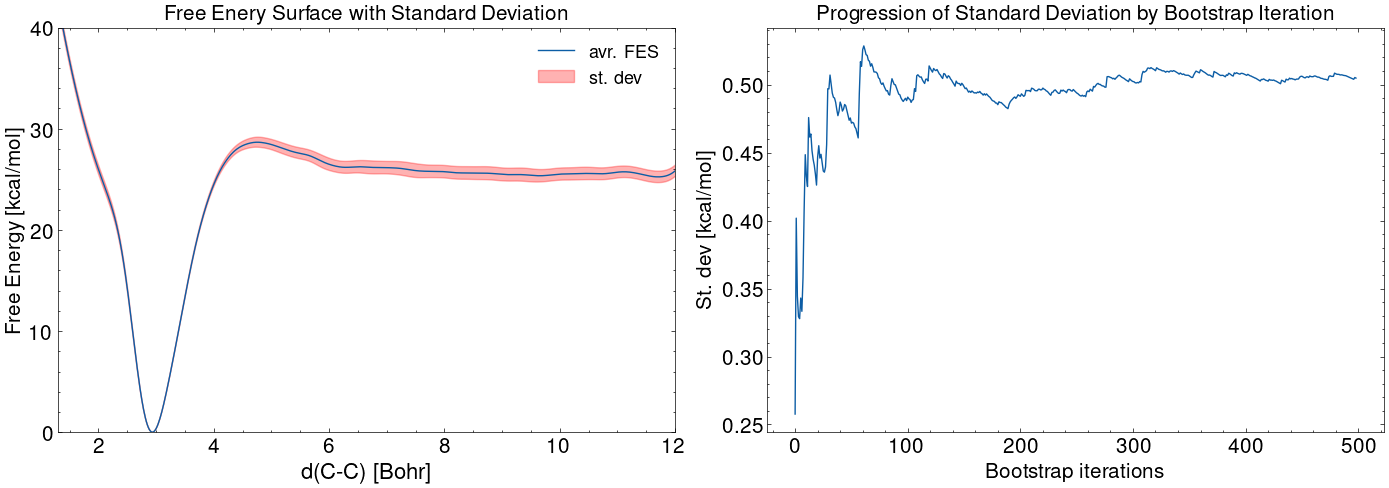

In [45]:
#Plot
plt.figure(figsize=(14,5)); plt.subplot(1,2,1)
plt.plot(X,(FES_avr_gas-np.min(FES_avr_gas)-8)/4.18, label="avr. FES")
plt.fill_between(X, (FES_avr_gas - sd_fes_gas - np.min(FES_avr_gas)-8)/4.18, (FES_avr_gas + sd_fes_gas - np.min(FES_avr_gas)-8)/4.18, alpha=0.3, color="red", label="st. dev")
plt.xlabel("d(C-C)"), plt.ylabel("Free Energy [kcal/mol]", fontsize=15); plt.legend(fontsize = 13); plt.title("Free Enery Surface with Standard Deviation", fontsize=15)
plt.ylim([0,40])
plt.xlim([1.3,12])
plt.xlabel('d(C-C) [Bohr]', fontsize = 16)
#plt.ylabel('FES projection [kcal/mol]',fontsize = 16)
plt.xticks([2,4,6,8,10,12],["2","4","6","8","10","12"] , fontsize=15)
plt.yticks([0,10,20,30,40], ["0", "10", "20", "30","40"], fontsize=15)

plt.subplot(1,2,2)
plt.plot(range(len(sd_fes_prog_gas)), np.asarray(sd_fes_prog_gas)/4.18)
plt.xlabel("Bootstrap iterations", fontsize=15), plt.ylabel("St. dev [kcal/mol]", fontsize=15); plt.title("Progression of Standard Deviation by Bootstrap Iteration", fontsize=15); 
#plt.ylim([0,40])
#plt.xlim([1.3,12])
plt.xticks([0,100,200,300,400,500],["0", "100", "200", "300","400", "500"] , fontsize=15)
plt.yticks(fontsize=15)
#plt.legend([ 'vacuum', "Water", "nBA monomer", "Xylene" ], fontsize = 13)
plt.tight_layout()
plt.savefig("free_energy_surf_1d_betasc_gas_510K.png", format="png", dpi=1200)

**Temperature trend**

In [10]:
import json
import codecs

fes_310K_gas_xtb_patch = str(path)+'Simulation Data/nButylAcrylate/BETASC/GAS/310K/'
fes_410K_gas_xtb_patch = str(path)+'Simulation Data/nButylAcrylate/BETASC/GAS/410K/'
fes_510K_gas_xtb_patch = str(path)+'Simulation Data/nButylAcrylate/BETASC/GAS/510K/'


f = open(str(fes_310K_gas_xtb_patch)+'fesavg_gas_310_1d.json','r')

fes_gas_1d_310K = np.array(json.load(f)).reshape(800)

var = open(str(fes_310K_gas_xtb_patch)+'std_gas_310_1d.json','r')
 
var_gas_1d_310K = np.array(json.load(var)).reshape(800)

f = open(str(fes_410K_gas_xtb_patch)+'fesavg_gas_410_1d.json','r')

fes_gas_1d_410K = np.array(json.load(f)).reshape(800)

var = open(str(fes_410K_gas_xtb_patch)+'std_gas_410_1d.json','r')
 
var_gas_1d_410K = np.array(json.load(var)).reshape(800)

f = open(str(fes_510K_gas_xtb_patch)+'fesavg_gas_510_1d.json','r')

fes_gas_1d_510K = np.array(json.load(f)).reshape(800)

var = open(str(fes_510K_gas_xtb_patch)+'std_gas_510_1d.json','r')
 
var_gas_1d_510K = np.array(json.load(var)).reshape(800)

29.73970642712223 0.5590883204523468 2.044590963537788 29.54562244912094 0.5175645339212702 1.9187699811662315 28.677569895257083 0.4506786525184861 1.8086766215911205


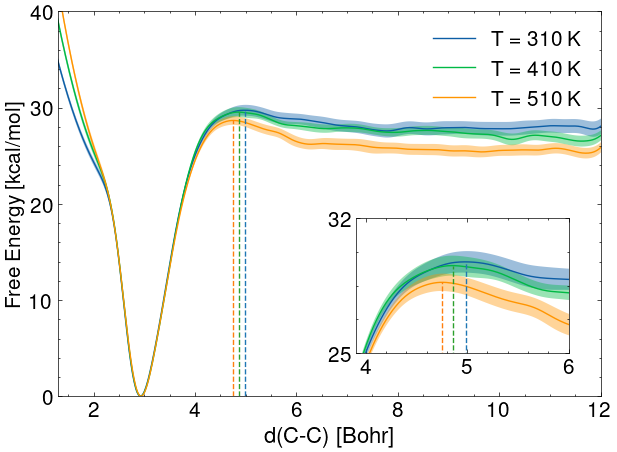

In [39]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

fig,ax = plt.subplots(figsize=(7,5))
#zax = zoomed_inset_axes(ax, 2, loc='center right')
# Create zoomed axes
zax = zoomed_inset_axes(ax, 2, loc=4, bbox_to_anchor=(0.45,0.1,0.5,0.5), bbox_transform=ax.transAxes)

#Plot
#plt.figure(figsize=(7,5)); #plt.subplot(1,2,1)
ax.plot(X,(fes_gas_1d_310K-np.min(fes_gas_1d_310K)-8)/4.18)
ax.fill_between(X, (fes_gas_1d_310K - var_gas_1d_310K  - np.min(fes_gas_1d_310K)-8)/4.18, (fes_gas_1d_310K + var_gas_1d_310K  - np.min(fes_gas_1d_310K)-8)/4.18, alpha=0.4, label='_nolegend_')
ax.plot(X,(fes_gas_1d_410K-np.min(fes_gas_1d_410K)-8)/4.18)
ax.fill_between(X, (fes_gas_1d_410K - var_gas_1d_410K  - np.min(fes_gas_1d_410K)-8)/4.18, (fes_gas_1d_410K + var_gas_1d_410K  - np.min(fes_gas_1d_410K)-8)/4.18, alpha=0.4, label='_nolegend_')
ax.plot(X,(fes_gas_1d_510K-np.min(fes_gas_1d_510K)-8)/4.18)
ax.fill_between(X, (fes_gas_1d_510K - var_gas_1d_510K  - np.min(fes_gas_1d_510K)-8)/4.18, (fes_gas_1d_510K + var_gas_1d_510K  - np.min(fes_gas_1d_510K)-8)/4.18, alpha=0.4, label='_nolegend_')
idx_310K = fes_gas_1d_310K.tolist().index(np.max(fes_gas_1d_310K.tolist()[200:700]))
idx_410K = fes_gas_1d_410K.tolist().index(np.max(fes_gas_1d_410K.tolist()[200:700]))
idx_510K = fes_gas_1d_510K.tolist().index(np.max(fes_gas_1d_510K.tolist()[200:700]))
idx_min =  fes_gas_1d_510K.tolist().index(np.min(fes_gas_1d_510K.tolist()[90:700]))
print((fes_gas_1d_310K[idx_310K]-8)/4.18, var_gas_1d_310K[idx_310K]/4.18 , (X[idx_310K]-X[idx_min]),(fes_gas_1d_410K[idx_410K]-8)/4.18, var_gas_1d_410K[idx_410K]/4.18, (X[idx_410K]-X[idx_min]),(fes_gas_1d_510K[idx_510K]-8)/4.18, var_gas_1d_510K[idx_510K]/4.18, (X[idx_510K]-X[idx_min]) )
ax.plot([X[idx_310K], X[idx_310K]], [np.min(fes_gas_1d_310K),(fes_gas_1d_310K[idx_310K]-8)/4.18], color='#1f77b4', linestyle='dashed')
ax.plot([X[idx_410K], X[idx_410K]], [np.min(fes_gas_1d_410K),(fes_gas_1d_410K[idx_410K]-8)/4.18], color='#2ca02c', linestyle='dashed')
ax.plot([X[idx_510K], X[idx_510K]], [np.min(fes_gas_1d_510K),(fes_gas_1d_510K[idx_510K]-8)/4.18], color='#ff7f0e', linestyle='dashed')

ax.set_xlabel("d(C-C)"), ax.set_ylabel("Free Energy [kcal/mol]", fontsize=15); #plt.title("Temperature trend", fontsize=15)
ax.set_ylim([0,40])
ax.set_xlim([1.3,12])
ax.set_xlabel('d(C-C) [Bohr]', fontsize = 16)
#plt.ylabel('FES projection [kcal/mol]',fontsize = 16)
ax.set_xticks([2,4,6,8,10,12],["2","4","6","8","10","12"] , fontsize=15)
ax.set_yticks([0,10,20,30,40], ["0", "10", "20", "30","40"], fontsize=15)
ax.legend([ "T = 310 K", "T = 410 K", "T = 510 K" ], loc='upper right', fontsize = 15)

zax.plot(X,(fes_gas_1d_310K-np.min(fes_gas_1d_310K)-8)/4.18, label="T = 310 K")
zax.fill_between(X, (fes_gas_1d_310K - var_gas_1d_310K  - np.min(fes_gas_1d_310K)-8)/4.18, (fes_gas_1d_310K + var_gas_1d_310K  - np.min(fes_gas_1d_310K)-8)/4.18, alpha=0.4)
zax.plot(X,(fes_gas_1d_410K-np.min(fes_gas_1d_410K)-8)/4.18, label="T = 410 K")
zax.fill_between(X, (fes_gas_1d_410K - var_gas_1d_410K  - np.min(fes_gas_1d_410K)-8)/4.18, (fes_gas_1d_410K + var_gas_1d_410K  - np.min(fes_gas_1d_410K)-8)/4.18, alpha=0.4)
zax.plot(X,(fes_gas_1d_510K-np.min(fes_gas_1d_510K)-8)/4.18, label="T = 510 K")
zax.fill_between(X, (fes_gas_1d_510K - var_gas_1d_510K  - np.min(fes_gas_1d_510K)-8)/4.18, (fes_gas_1d_510K + var_gas_1d_510K  - np.min(fes_gas_1d_510K)-8)/4.18, alpha=0.4)
zax.plot([X[idx_310K], X[idx_310K]], [np.min(fes_gas_1d_310K),(fes_gas_1d_310K[idx_310K]-8)/4.18], color='#1f77b4', linestyle='dashed')
zax.plot([X[idx_410K], X[idx_410K]], [np.min(fes_gas_1d_410K),(fes_gas_1d_410K[idx_410K]-8)/4.18], color='#2ca02c', linestyle='dashed')
zax.plot([X[idx_510K], X[idx_510K]], [np.min(fes_gas_1d_510K),(fes_gas_1d_510K[idx_510K]-8)/4.18], color='#ff7f0e', linestyle='dashed')
zax.set_ylim([25,32])
zax.set_xlim([3.9,6.0])
zax.set_xticks([4,5,6],["4","5","6"] , fontsize=15)
zax.set_yticks([25,32], ["25", "32"], fontsize=15)
zax.tick_params(axis='both', labelsize=15)
plt.savefig("free_energy_surf_1d_betasc_gas_temp.png", format="png", dpi=1200)

In [13]:
# Entropy and Enthalpy profiles
from sklearn.linear_model import LinearRegression

entropy = []
enthalpy = []
std_entropy = []
std_enthalpy = []

fes = np.vstack([fes_gas_1d_310K,fes_gas_1d_410K,fes_gas_1d_510K])
std_fes = np.vstack([var_gas_1d_310K,var_gas_1d_410K,var_gas_1d_510K])

T = np.array([310,410,510]).reshape((-1,1))
corr_b0 = np.sqrt(np.sum([310**2,410**2,510**2])/(3*np.sum([310**2,410**2,510**2])-(np.sum([310**2,410**2,510**2]))))
corr_b1 = np.sqrt(3/(3*np.sum([310**2,410**2,510**2])-(np.sum([310**2,410**2,510**2]))))

#print(corr_b0,corr_b1)

for i in np.arange(0,len(X)):
    DF = np.array([fes[0,i],fes[1,i],fes[2,i]])
    std_y = np.array([std_fes[0,i],std_fes[1,i],std_fes[2,i]])
    line = LinearRegression().fit(T,DF)
    Sy = np.sum((line.predict(T) - DF)**2)
    Sy = np.sqrt((std_y[0]**2+std_y[1]**2+std_y[2]**2))
    DS = line.coef_
    DH = line.intercept_
    entropy.append(DS)
    enthalpy.append(DH)
    std_entropy.append(Sy*corr_b1)
    std_enthalpy.append(Sy*corr_b0)
    
std_entropy = np.array(std_entropy).reshape(800)
std_enthalpy = np.array(std_enthalpy).reshape(800)

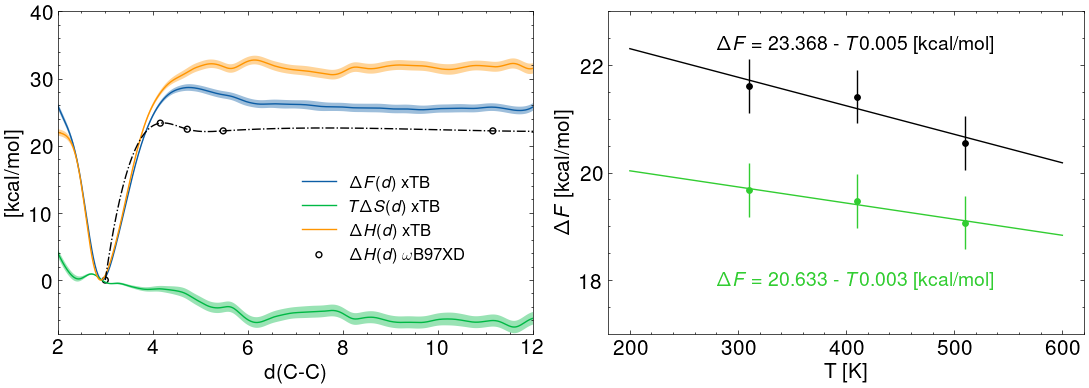

In [15]:
import matplotlib.gridspec as gridspec
from scipy.interpolate import make_interp_spline
from sklearn.linear_model import LinearRegression

fig = plt.figure(figsize=(11,4))

gs = gridspec.GridSpec(1,2, width_ratios=[1,1])

ax0 = plt.subplot(gs[0,0])

U_wb97xd = [-809.749844,-809.712612,-809.714059,-809.714445, -809.714451, -809.714451]
DU_wb97xd = (U_wb97xd-np.min(U_wb97xd))*627.509
H_wb97xd = [-809.728589,-809.690255,-809.691170,-809.692100,-809.692105,-809.692105]
DH_wb97xd = (H_wb97xd-np.min(H_wb97xd))*627.509

d = [3.0,2.2*1.889,2.5*1.889,2.9*1.889,5.9*1.889,7*1.889]

X_Y_Spline = make_interp_spline(d, DU_wb97xd)
X_ = np.linspace(np.min(d), np.max(d), 500)
Y_ = X_Y_Spline(X_)

#fig = plt.figure(figsize=(5,4))
ax0.plot(X,(fes_gas_1d_510K-8)/4.18)
ax0.fill_between(X, (fes_gas_1d_510K - var_gas_1d_510K  - np.min(fes_gas_1d_510K)-8)/4.18, (fes_gas_1d_510K + var_gas_1d_510K  - np.min(fes_gas_1d_510K)-8)/4.18, alpha=0.4, label='_nolegend_')
ax0.plot(X,510*np.array(entropy).reshape(800)/4.18)
ax0.fill_between(X, 510*(np.array(entropy).reshape(800) - std_entropy)/4.18, 510*(np.array(entropy).reshape(800) + std_entropy)/4.18, alpha=0.4, label='_nolegend_')
ax0.plot(X,(np.array(enthalpy)-8)/4.18)
ax0.fill_between(X, (np.array(enthalpy) - np.array(std_enthalpy)  - np.min(fes_gas_1d_310K)-8)/4.18, (np.array(enthalpy) + np.array(std_enthalpy)  - np.min(fes_gas_1d_310K)-8)/4.18, alpha=0.4, label='_nolegend_')
ax0.scatter(d,DU_wb97xd,s=18,marker='o',facecolors='none', edgecolors='k')
ax0.plot(X_,Y_,color='k',linestyle='dashdot')
ax0.set_ylim([-8,40])
ax0.set_xlim([2,12])
ax0.set_xlabel("d(C-C)", fontsize=15), plt.ylabel("[kcal/mol]", fontsize=15); #plt.title("Temperature trend", fontsize=15)
#plt.ylabel('FES projection [kcal/mol]',fontsize = 16)
ax0.set_xticks([2,4,6,8,10,12],["2","4","6","8","10","12"] , fontsize=15)
ax0.set_yticks([0,10,20,30,40], ["0", "10", "20", "30","40"], fontsize=15)
ax0.legend([ "$\Delta F(d) $ xTB", "$T\Delta S(d) $ xTB", "$\Delta H(d) $ xTB", "$\Delta H(d) $  $\omega$B97XD" ], loc=(0.5,0.2), fontsize = 12)

ax1 = plt.subplot(gs[0,1])

#fig = plt.figure(figsize=(5,4))
DF = np.array([29.739706, 29.5456224491, 28.6775698952])
DFw = np.array([27.8, 27.6, 27.2])
DF=DF-8.13
DFw=DFw-8.13
T = np.array([310,410,510]).reshape((-1,1))
std = np.array([0.5,0.5,0.5])
temperature = np.linspace(200,600,1000).reshape((-1,1))

line = LinearRegression().fit(T,DF)
DS = line.coef_
DH = line.intercept_

line_w = LinearRegression().fit(T,DFw)
DSw = line_w.coef_
DHw = line_w.intercept_

DS = DS[0].round(3)
DH = DH.round(3)
DSw = DSw[0].round(3)
DHw = DHw.round(3)

ax1.scatter(T, DF, s=15, color='k')
ax1.errorbar(T,DF,yerr=std, color='k', fmt='o')
ax1.plot(temperature,line.predict(temperature), color='k',label='gas')
ax1.scatter(T, DFw, s=15,color='limegreen')
ax1.errorbar(T,DFw,yerr=std, fmt='o', color='limegreen')
ax1.plot(temperature,line_w.predict(temperature), color='limegreen', label='water')
ax1.set_ylim(17,23)
ax1.text(280,22.3,'$\Delta F $ = '+str(DH)+' - $ T $'+str(-DS)+' [kcal/mol]', fontsize=14)
ax1.text(280,17.9,'$\Delta F $ = '+str(DHw)+' - $ T $'+str(-DSw)+' [kcal/mol]', fontsize=14, color='limegreen')
ax1.set_xlabel("T [K]", fontsize=15), plt.ylabel(" $\Delta F$ [kcal/mol]", fontsize=15); plt.tight_layout()
ax1.set_xticks([200,300,400,500,600],["200", "300", "400", "500", "600"] , fontsize=15)
#plt.yticks([27,28,29,30,31],["27","28", "29", "30", "31"] , fontsize=15)
ax1.set_yticks([18,20,22],["18","20", "22"] , fontsize=15)
#plt.legend([ 'vacuum', "Water", "nBA monomer", "Xylene" ], fontsize = 13)
#ax1.savefig("free_energy_temperature.png", format="png", dpi=1200)
plt.tight_layout()
plt.savefig("enthalpy_entropy.png", format="png", dpi=1200)

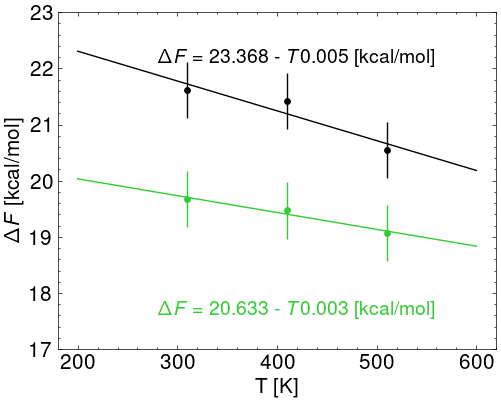

In [29]:
from sklearn.linear_model import LinearRegression
fig = plt.figure(figsize=(5,4))
DF = np.array([29.739706, 29.5456224491, 28.6775698952])
DFw = np.array([27.8, 27.6, 27.2])
DF=DF-8.13
DFw=DFw-8.13
T = np.array([310,410,510]).reshape((-1,1))
std = np.array([0.5,0.5,0.5])
temperature = np.linspace(200,600,1000).reshape((-1,1))

line = LinearRegression().fit(T,DF)
DS = line.coef_
DH = line.intercept_

line_w = LinearRegression().fit(T,DFw)
DSw = line_w.coef_
DHw = line_w.intercept_

#print(DH,DS)
#print(DHw,DSw)

DS = DS[0].round(3)
DH = DH.round(3)
DSw = DSw[0].round(3)
DHw = DHw.round(3)

plt.scatter(T, DF, s=15, color='k')
plt.errorbar(T,DF,yerr=[std_entropy*310,std_entropy*410,std_entropy*510], color='k', fmt='o')
plt.plot(temperature,line.predict(temperature), color='k',label='gas')
plt.scatter(T, DFw, s=15,color='limegreen')
plt.errorbar(T,DFw,yerr=[std_entropy*310,std_entropy*410,std_entropy*510], fmt='o', color='limegreen')
plt.plot(temperature,line_w.predict(temperature), color='limegreen', label='water')
plt.ylim(17,23)
plt.text(280,22.1,'$\Delta F $ = '+str(DH)+' - $ T $'+str(-DS)+' [kcal/mol]', fontsize=14)
plt.text(280,17.6,'$\Delta F $ = '+str(DHw)+' - $ T $'+str(-DSw)+' [kcal/mol]', fontsize=14, color='limegreen')
plt.xlabel("T [K]", fontsize=15), plt.ylabel(" $\Delta F$ [kcal/mol]", fontsize=15); plt.tight_layout()
plt.xticks([200,300,400,500,600],["200", "300", "400", "500", "600"] , fontsize=15)
#plt.yticks([27,28,29,30,31],["27","28", "29", "30", "31"] , fontsize=15)
plt.yticks( fontsize=15)
#plt.legend([ 'vacuum', "Water", "nBA monomer", "Xylene" ], fontsize = 13)
plt.savefig("free_energy_temperature.png", format="png", dpi=1200)

## **II)** Monomer (Bulk) free energy surface @ 410 K with GNFN1 XTB

In [16]:
fes_410K_bulk_xtb_patch = str(path)+'Simulation Data/nButylAcrylate/BETASC/MON/410K/'

forces_all = []
master = []
all_hills= []
error_history = []
Ftot_master = []
master_patch = [[np.zeros((400,800)), np.zeros((400,800)), np.zeros((400,800)), np.zeros((400,800)), np.zeros((400,800)), np.zeros((400,800))]]
FP = np.zeros((400,800))
ofe_history_patch = [0]
ofe_history_patch_time = [0]
X = np.linspace(0, 4*np.pi, 800)
Y = np.linspace(-np.pi, np.pi, 400)
dx = np.abs( X[0] - X[1] )
dy = np.abs( Y[0] - Y[1] )

In [17]:
#metadyn2hills(sigma_x,sigma_y,gamma,hartree_2_kj, 6, 8, fes_410K_bulk_xtb_patch,60)

|**************************************************| 100% | Bootstrap Average Standard Deviation: 1.871

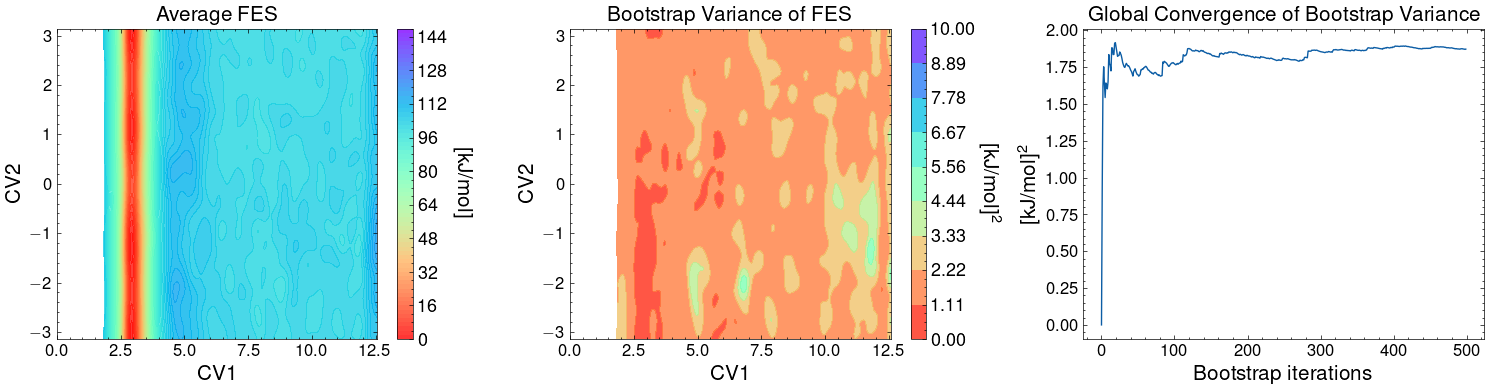

In [18]:
n_simulations = 11

for simulation in np.arange(1,n_simulations+1):

    HILLS=MFI.load_HILLS_2D(hills_name=str(fes_410K_bulk_xtb_patch)+"HILLS_"+str(simulation))
    
    #Read the Colvar File
    [position_x, position_y] = MFI.load_position_2D(position_name=str(fes_410K_bulk_xtb_patch)+"position_"+str(simulation))
    #COMPUTE Mean force and weight of the simulation
    [X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, time_history, Ftot_den2, ofv_num_x, ofv_num_y] = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw_x = 0.2, bw_y = 0.2, kT = 3.4, min_grid = np.array((0, -np.pi)), max_grid = np.array((4*np.pi, np.pi)), nbins = np.array((400,800)), log_pace = 100, error_pace = 100, base_terms=0, window_corners=[], WellTempered = 0, nhills=-1, periodic_x=0, periodic_y=1, FES_cutoff=150)

    forces_all.append([X, Y, Ftot_den, Ftot_x, Ftot_y])

    master.append([Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_y])

    master_patch.append(MFI.patch_2D(master))
    
    ofe_history_patch += ofe_history
    ofe_history_time_adj = [element+ofe_history_patch_time[-1] for element in time_history]
    ofe_history_patch_time += ofe_history_time_adj
    

#change forces_all to format: [Ftot_den, Ftot_x, Ftot_y]
forces_all_ = np.asarray(forces_all)[:,[2,3,4],:,:]

[FES_avr_bulk_2d, sd_fes_bulk_2d, sd_fes_prog_bulk_2d ] = MFI.bootstrap_2D_new(X, Y, forces_all_, n_bootstrap=500, FES_cutoff=150)

MFI.plot_bootstrap(X, Y, MFI.zero_to_nan(np.where(master_patch[-1][0] > 0.1, FES_avr_bulk_2d, 0)), MFI.zero_to_nan(np.where(master_patch[-1][0] > 0.1, sd_fes_bulk_2d, 0)), sd_fes_prog_bulk_2d, FES_lim=150, ofe_lim=10)
plt.tight_layout()
plt.savefig("free_energy_surf_betasc_bulk_410K.png", format="png", dpi=1200)
plt.show()

In [19]:
import json
import codecs

stdtosave = sd_fes_bulk_2d.tolist()
sdjson = json.dump(stdtosave, codecs.open(str(fes_410K_bulk_xtb_patch)+'std_liq410_32000.json','w', encoding = 'utf-8'))

fesavgtosave = FES_avr_bulk_2d.tolist()
fes_avgjson = json.dump(fesavgtosave, codecs.open(str(fes_410K_bulk_xtb_patch)+'fesavg_liq410_32000.json','w', encoding = 'utf-8'))

sdprog_2d = sd_fes_prog_bulk_2d.tolist()
sdprog_2d = json.dump(sdprog_2d, codecs.open(str(fes_410K_bulk_xtb_patch)+'sdprog_liq410_32000.json','w', encoding = 'utf-8'))

In [20]:
f = open(str(fes_410K_bulk_xtb_patch)+'fesavg_liq410_32000.json','r')

Z_matrix_bulk = np.array(json.load(f)).reshape(400,800)

var = open(str(fes_410K_bulk_xtb_patch)+'std_liq410_32000.json','r')
Var_bulk = np.array(json.load(var)).reshape(400,800)

sdprog_bulk = open(str(fes_410K_bulk_xtb_patch)+'std_liq410_32000.json','r')
sdprog_bulk_2d = np.array(json.load(sdprog_bulk))

100 FES st. dev. = 1.405
200 FES st. dev. = 1.356
300 FES st. dev. = 1.358
400 FES st. dev. = 1.358
500 FES st. dev. = 1.361


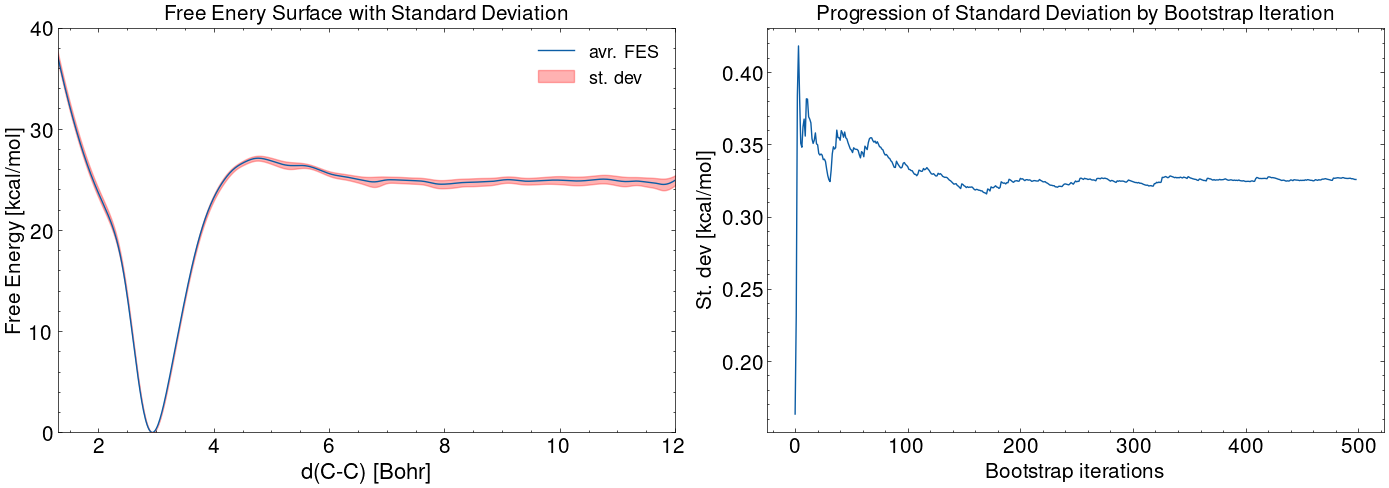

In [21]:
import importlib
importlib.reload(MFI)

X = np.linspace(0, 4*np.pi, 800)
Y = np.linspace(-np.pi, np.pi, 400)
[FES_avr_bulk, cutoff, sd_fes_bulk, sd_fes_prog_bulk ] = MFI.bootstrap_1D_fes(X, Y, forces_all_, n_bootstrap=500, FES_cutoff=150, FFT_integration=1, min_grid=np.array((0,-np.pi)), max_grid=np.array((4*np.pi,np.pi)))

X = np.linspace(0, 4*np.pi, 800)
#Plot
plt.figure(figsize=(14,5)); plt.subplot(1,2,1)
plt.plot(X,(FES_avr_bulk-np.min(FES_avr_bulk[100:]))/4.18, label="avr. FES")
plt.fill_between(X, (FES_avr_bulk - sd_fes_bulk - np.min(FES_avr_bulk[100:]))/4.18, (FES_avr_bulk + sd_fes_bulk - np.min(FES_avr_bulk[100:]))/4.18, alpha=0.3, color="red", label="st. dev")
plt.xlabel("d(C-C)"), plt.ylabel("Free Energy [kcal/mol]", fontsize=15); plt.legend(fontsize = 13); plt.title("Free Enery Surface with Standard Deviation", fontsize=15)
plt.ylim([0,40])
plt.xlim([1.3,12])
plt.xlabel('d(C-C) [Bohr]', fontsize = 16)
#plt.ylabel('FES projection [kcal/mol]',fontsize = 16)
plt.xticks([2,4,6,8,10,12],["2","4","6","8","10","12"] , fontsize=15)
plt.yticks([0,10,20,30,40], ["0", "10", "20", "30","40"], fontsize=15)

plt.subplot(1,2,2)
plt.plot(range(len(sd_fes_prog_bulk)), np.asarray(sd_fes_prog_bulk)/4.18)
plt.xlabel("Bootstrap iterations", fontsize=15), plt.ylabel("St. dev [kcal/mol]", fontsize=15); plt.title("Progression of Standard Deviation by Bootstrap Iteration", fontsize=15); 
#plt.ylim([0,40])
#plt.xlim([1.3,12])
plt.xticks([0,100,200,300,400,500],["0", "100", "200", "300","400", "500"] , fontsize=15)
plt.yticks(fontsize=15)
#plt.legend([ 'vacuum', "Water", "nBA monomer", "Xylene" ], fontsize = 13)
plt.tight_layout()
plt.savefig("free_energy_surf_1d_betasc_bulk_410K.png", format="png", dpi=1200)

In [22]:
import json
import codecs

stdtosave = sd_fes_bulk.tolist()
sdjson = json.dump(stdtosave, codecs.open(str(fes_410K_bulk_xtb_patch)+'std_bulk_410_1d.json','w', encoding = 'utf-8'))

fesavgtosave = FES_avr_bulk.tolist()
fes_avgjson = json.dump(fesavgtosave, codecs.open(str(fes_410K_bulk_xtb_patch)+'fesavg_bulk_410_1d.json','w', encoding = 'utf-8'))

sdprogjson = json.dump(sd_fes_prog_bulk, codecs.open(str(fes_410K_bulk_xtb_patch)+'sdprog_bulk_410_1d.json','w', encoding = 'utf-8'))

In [23]:
f = open(str(fes_410K_bulk_xtb_patch)+'fesavg_bulk_410_1d.json','r')
fes_bulk_1d = np.array(json.load(f)).reshape(800)

var = open(str(fes_410K_bulk_xtb_patch)+'std_bulk_410_1d.json','r') 
sd_bulk_1d = np.array(json.load(var)).reshape(800)

sdprog = open(str(fes_410K_bulk_xtb_patch)+'sdprog_bulk_410_1d.json','r')
sdprog_bulk_1d = np.array(json.load(sdprog))

## **III)** Xylene Solvent @410K GNFN1 XTB 

In [47]:
#from pyMFI import MFI
fes_410K_xyl_xtb_patch =  str(path)+'Simulation Data/nButylAcrylate/BETASC/XYL/410K/'

forces_all = []
master = []
all_hills= []
error_history = []
Ftot_master = []
master_patch = [[np.zeros((400,800)), np.zeros((400,800)), np.zeros((400,800)), np.zeros((400,800)), np.zeros((400,800)), np.zeros((400,800))]]
FP = np.zeros((400,800))
ofe_history_patch = [0]
ofe_history_patch_time = [0]
X = np.linspace(0, 4*np.pi, 800)
Y = np.linspace(-np.pi, np.pi,400)
time_history_patch = []
volume_history_patch = []
error_history =[]

dx = np.abs( X[0] - X[1] )
dy = np.abs( Y[0] - Y[1] )

In [25]:
#metadyn2hills(sigma_x,sigma_y,gamma,hartree_2_kj, 7, 10, fes_410K_xyl_xtb_patch,60)

|**************************************************| 100% | Bootstrap Average Standard Deviation: 2.722

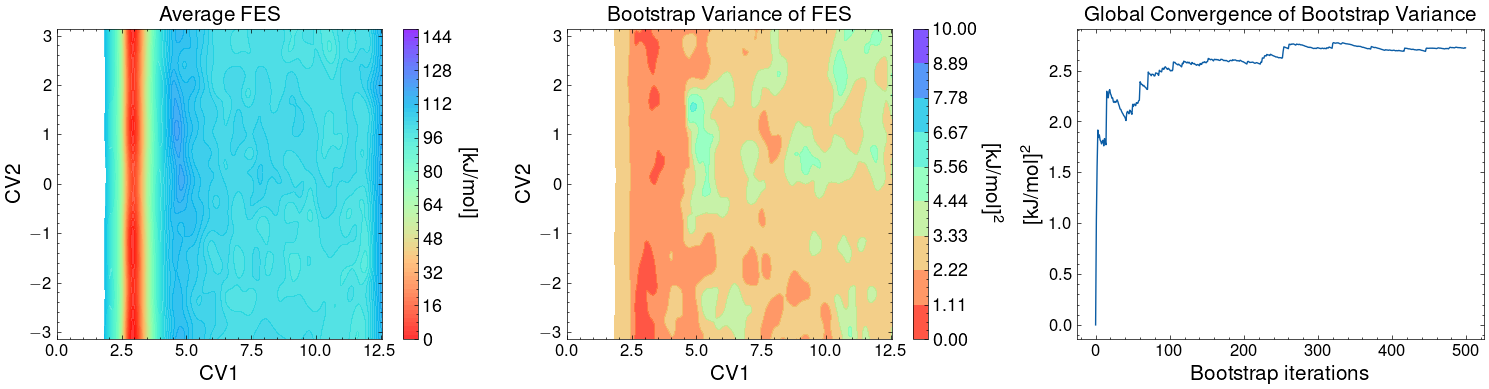

In [48]:
n_simulations = 10

for simulation in np.arange(1,n_simulations+1):

    HILLS=MFI.load_HILLS_2D(hills_name=str(fes_410K_xyl_xtb_patch)+"HILLS_"+str(simulation))
    
    #Read the Colvar File
    [position_x, position_y] = MFI.load_position_2D(position_name=str(fes_410K_xyl_xtb_patch)+"position_"+str(simulation))
    #COMPUTE Mean force and weight of the simulation
    [X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, time_history, Ftot_den2, ofv_num_x, ofv_num_y] = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw_x = 0.2, bw_y = 0.2, kT = 3.4, min_grid = np.array((0, -np.pi)), max_grid = np.array((4*np.pi, np.pi)), nbins = np.array((400,800)), log_pace = 100, error_pace = 100, base_terms=0, window_corners=[], WellTempered = 0, nhills=-1, periodic_x=0, periodic_y=1, FES_cutoff=150)

    forces_all.append([X, Y, Ftot_den, Ftot_x, Ftot_y])

    master.append([Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_y])

    master_patch.append(MFI.patch_2D(master))
    
    ofe_history_patch += ofe_history
    ofe_history_time_adj = [element+ofe_history_patch_time[-1] for element in time_history]
    ofe_history_patch_time += ofe_history_time_adj
    

### Bootstrap ######
forces_all_ = np.asarray(forces_all)[:,[2,3,4],:,:]

[FES_avr_xyl_2d, sd_fes_xyl_2d, sd_fes_prog_xyl_2d ] = MFI.bootstrap_2D_new(X, Y, forces_all_, n_bootstrap=500, FES_cutoff=150)
MFI.plot_bootstrap(X, Y, MFI.zero_to_nan(np.where(master_patch[-1][0] > 0.1, FES_avr_xyl_2d, 0)), MFI.zero_to_nan(np.where(master_patch[-1][0] > 0.1, sd_fes_xyl_2d, 0)), sd_fes_prog_xyl_2d, FES_lim=150, ofe_lim=10)
plt.tight_layout()
plt.savefig("free_energy_surf_betasc_xyl_410K.png", format="png", dpi=1200)
plt.show()

In [1]:
fesavgtosave = FES_avr.tolist()
fes_avgjson = json.dump(fesavgtosave, codecs.open(str(fes_410K_xyl_xtb_patch)+'fesavg_xyl_wall_410.json','w', encoding = 'utf-8'))

In [49]:
import json
import codecs

stdtosave = sd_fes_xyl_2d.tolist()
sdjson = json.dump(stdtosave, codecs.open(str(fes_410K_xyl_xtb_patch)+'std_liq410_320000.json','w', encoding = 'utf-8'))

fesavgtosave = FES_avr_xyl_2d.tolist()
fes_avgjson = json.dump(fesavgtosave, codecs.open(str(fes_410K_xyl_xtb_patch)+'fesavg_liq410_320000.json','w', encoding = 'utf-8'))

sdprog_2d = sd_fes_prog_xyl_2d.tolist()
sdprog_2d = json.dump(sdprog_2d, codecs.open(str(fes_410K_xyl_xtb_patch)+'sdprog_liq410_32000.json','w', encoding = 'utf-8'))

In [50]:
f = open(str(fes_410K_xyl_xtb_patch)+'fesavg_liq410_320000.json','r')

Z_matrix_xyl = np.array(json.load(f)).reshape(400,800)

var = open(str(fes_410K_xyl_xtb_patch)+'std_liq410_320000.json','r')
variance = json.load(var)

Var_xyl = np.array(variance).reshape(400,800)

sdprog_xyl = open(str(fes_410K_xyl_xtb_patch)+'sdprog_liq410_32000.json','r')
sdprog_xyl_2d = np.array(json.load(sdprog_xyl))

100 FES st. dev. = 2.495
200 FES st. dev. = 2.405
300 FES st. dev. = 2.476
400 FES st. dev. = 2.47
500 FES st. dev. = 2.456


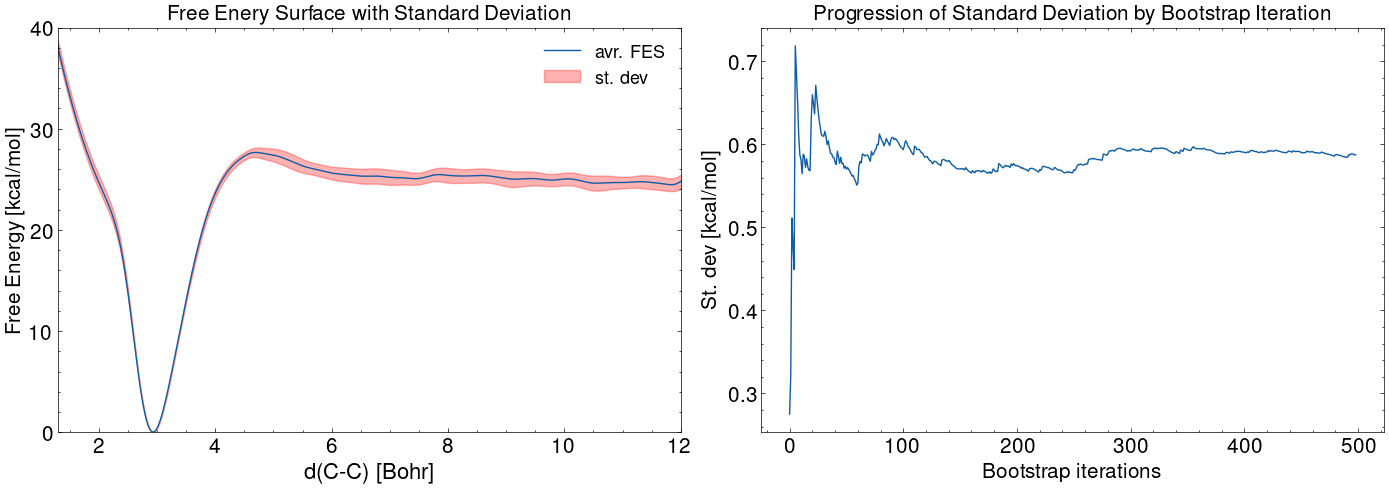

In [51]:
import importlib
importlib.reload(MFI)

X = np.linspace(0, 4*np.pi, 800)
Y = np.linspace(-np.pi, np.pi, 400)
[FES_avr_xyl, cutoff, sd_fes_xyl, sd_fes_prog_xyl ] = MFI.bootstrap_1D_fes(X, Y, forces_all_, n_bootstrap=500, FES_cutoff=150, FFT_integration=1, min_grid = np.array((0, -np.pi)), max_grid = np.array((4*np.pi, np.pi)) )
X = np.linspace(0, 4*np.pi, 800)
#Plot
plt.figure(figsize=(14,5)); plt.subplot(1,2,1)
plt.plot(X,(FES_avr_xyl-np.min(FES_avr_xyl)-8)/4.18, label="avr. FES")
plt.fill_between(X, (FES_avr_xyl - sd_fes_xyl - np.min(FES_avr_xyl)-8)/4.18, (FES_avr_xyl + sd_fes_xyl - np.min(FES_avr_xyl)-8)/4.18, alpha=0.3, color="red", label="st. dev")
plt.xlabel("d(C-C)"), plt.ylabel("Free Energy [kcal/mol]", fontsize=15); plt.legend(fontsize = 13); plt.title("Free Enery Surface with Standard Deviation", fontsize=15)
plt.ylim([0,40])
plt.xlim([1.3,12])
plt.xlabel('d(C-C) [Bohr]', fontsize = 16)
plt.xticks([2,4,6,8,10,12],["2","4","6","8","10","12"] , fontsize=15)
plt.yticks([0,10,20,30,40], ["0", "10", "20", "30","40"], fontsize=15)

plt.subplot(1,2,2)
plt.plot(range(len(sd_fes_prog_xyl)), np.asarray(sd_fes_prog_xyl)/4.18)
plt.xlabel("Bootstrap iterations", fontsize=15), plt.ylabel("St. dev [kcal/mol]", fontsize=15); plt.title("Progression of Standard Deviation by Bootstrap Iteration", fontsize=15); 
plt.xticks([0,100,200,300,400,500],["0", "100", "200", "300","400", "500"] , fontsize=15)
plt.yticks( fontsize=15)
plt.tight_layout()
plt.savefig("free_energy_surf_1d_betasc_xyl_410K.png", format="png", dpi=1200)

In [52]:
import json
import codecs

stdtosave = sd_fes_xyl.tolist()
sdjson = json.dump(stdtosave, codecs.open(str(fes_410K_xyl_xtb_patch)+'std_xyl_410_1d.json','w', encoding = 'utf-8'))

fesavgtosave = FES_avr_xyl.tolist()
fes_avgjson = json.dump(fesavgtosave, codecs.open(str(fes_410K_xyl_xtb_patch)+'fesavg_xyl_410_1d.json','w', encoding = 'utf-8'))

sdprogjson = json.dump(sd_fes_prog_xyl, codecs.open(str(fes_410K_xyl_xtb_patch)+'sdprog_xyl_410_1d.json','w', encoding = 'utf-8'))

In [53]:
f = open(str(fes_410K_xyl_xtb_patch)+'fesavg_xyl_410_1d.json','r')

fes_xyl_1d = np.array(json.load(f)).reshape(800)

var = open(str(fes_410K_xyl_xtb_patch)+'std_xyl_410_1d.json','r')
variance = json.load(var)

sd_xyl_1d = np.array(variance).reshape(800)

sdprog = open(str(fes_410K_xyl_xtb_patch)+'sdprog_xyl_410_1d.json','r')
sdprog_xyl_1d = np.array(json.load(sdprog))

## **III)** Water Solvent @310K GNFN1 XTB 

In [102]:
fes_310K_wat_xtb_patch =  str(path)+'Simulation Data/nButylAcrylate/BETASC/WAT/310K/'

forces_all = []
master = []
all_hills= []
error_history = []
Ftot_master = []
master_patch = [[np.zeros((400,800)), np.zeros((400,800)), np.zeros((400,800)), np.zeros((400,800)), np.zeros((400,800)), np.zeros((400,800))]]
FP = np.zeros((400,800))
ofe_history_patch = [0]
ofe_history_patch_time = [0]
X = np.linspace(0, 4*np.pi, 800)
Y = np.linspace(-np.pi, np.pi, 400)
time_history_patch = []
volume_history_patch = []
error_history =[]
dx = np.abs( X[0] - X[1] )
dy = np.abs( Y[0] - Y[1] )

In [23]:
#metadyn2hills(sigma_x,sigma_y,gamma,hartree_2_kj, 1,5 , fes_310K_wat_xtb_patch,60)

|***************                                   | 29% | Average Mean Force Error: nan63

C:\Users/fserse/Desktop/PhD_Thesis/Kinetics from Metadynamics/Libraries/src/pymfi\pyMFI\MFI.py:500: RuntimeWarning: invalid value encountered in sqrt
  ofe_x = np.sqrt(ofv_x)
C:\Users/fserse/Desktop/PhD_Thesis/Kinetics from Metadynamics/Libraries/src/pymfi\pyMFI\MFI.py:501: RuntimeWarning: invalid value encountered in sqrt
  ofe_y = np.sqrt(ofv_y)


|**************************************************| 100% | Bootstrap Average Standard Deviation: 3.107

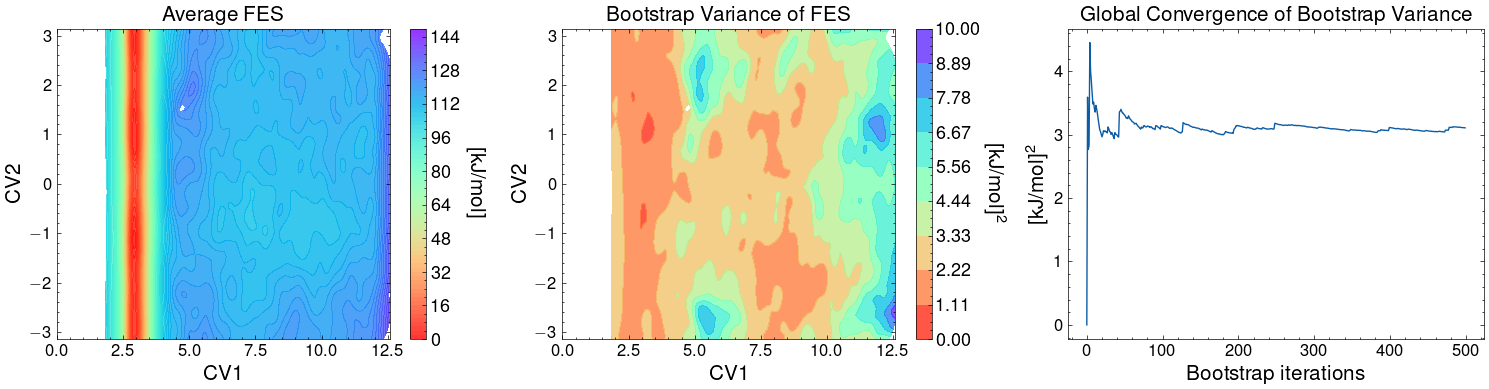

In [24]:
n_simulations = 10

for simulation in np.arange(1,n_simulations+1):

    HILLS=MFI.load_HILLS_2D(hills_name=str(fes_310K_wat_xtb_patch)+"HILLS_"+str(simulation))
    
    #Read the Colvar File
    [position_x, position_y] = MFI.load_position_2D(position_name=str(fes_310K_wat_xtb_patch)+"position_"+str(simulation))
    #COMPUTE Mean force and weight of the simulation
    [X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, time_history, Ftot_den2, ofv_num_x, ofv_num_y] = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw_x = 0.2, bw_y = 0.2, kT = 2.58, min_grid = np.array((0, -np.pi)), max_grid = np.array((4*np.pi, np.pi)), nbins = np.array((400,800)), log_pace = 100, error_pace = 100, base_terms=0, window_corners=[], WellTempered = 0, nhills=-1, periodic_x=0, periodic_y=1, FES_cutoff=150)

    forces_all.append([X, Y, Ftot_den, Ftot_x, Ftot_y])

    master.append([Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_y])

    master_patch.append(MFI.patch_2D(master))
    
    ofe_history_patch += ofe_history
    ofe_history_time_adj = [element+ofe_history_patch_time[-1] for element in time_history]
    ofe_history_patch_time += ofe_history_time_adj
    

forces_all_ = np.asarray(forces_all)[:,[2,3,4],:,:]

[FES_avr_wat_2d, sd_fes_wat_2d, sd_fes_prog_wat_2d ] = MFI.bootstrap_2D_new(X, Y, forces_all_, n_bootstrap=500, FES_cutoff=150)

MFI.plot_bootstrap(X, Y, MFI.zero_to_nan(np.where(master_patch[-1][0] > 0.1, FES_avr_wat_2d, 0)), MFI.zero_to_nan(np.where(master_patch[-1][0] > 0.1, sd_fes_wat_2d, 0)), sd_fes_prog_wat_2d, FES_lim=150, ofe_lim=10)
plt.tight_layout()
plt.savefig("free_energy_surf_betasc_wat_310K_32k.png", format="png", dpi=1200)
#plt.show()

In [25]:
import json
import codecs

stdtosave = sd_fes_wat_2d.tolist()
sdjson = json.dump(stdtosave, codecs.open(str(fes_310K_wat_xtb_patch)+'std_wat_310.json','w', encoding = 'utf-8'))

fesavgtosave = FES_avr_wat_2d.tolist()
fes_avgjson = json.dump(fesavgtosave, codecs.open(str(fes_310K_wat_xtb_patch)+'fesavg_wat_310.json','w', encoding = 'utf-8'))

In [26]:
f = open(str(fes_310K_wat_xtb_patch)+'fesavg_wat_310.json','r')

Z_matrix_wat = np.array(json.load(f)).reshape(400,800)

var = open(str(fes_310K_wat_xtb_patch)+'std_wat_310.json','r')
variance = json.load(var)

var_wat = np.array(variance).reshape(400,800)

100 FES st. dev. = 2.514
200 FES st. dev. = 2.494
300 FES st. dev. = 2.51
400 FES st. dev. = 2.472
500 FES st. dev. = 2.471


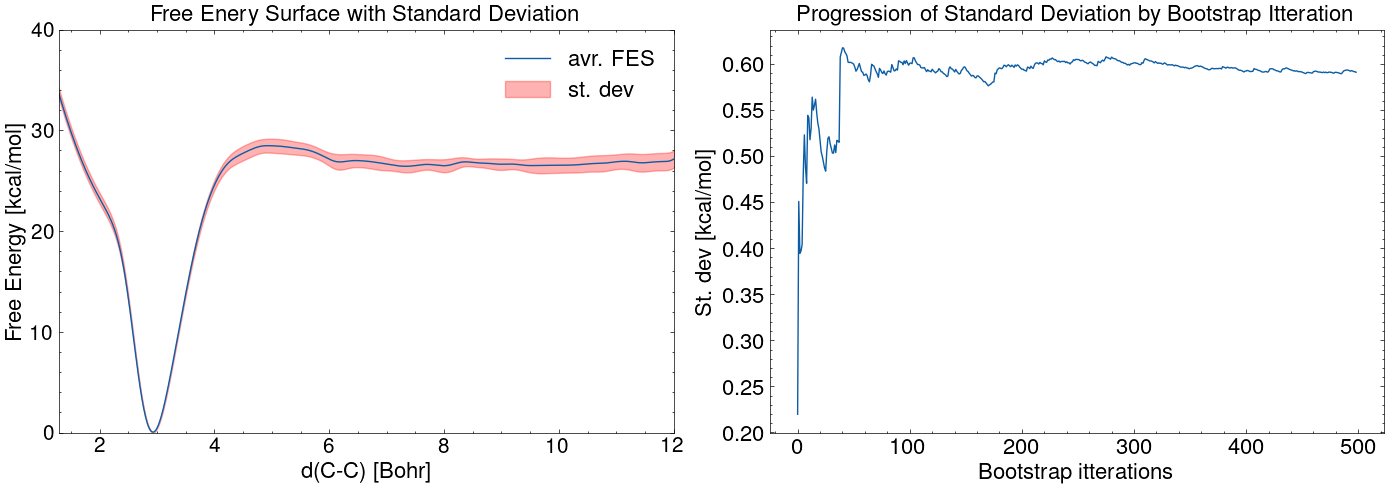

In [27]:
import importlib
importlib.reload(MFI)

X = np.linspace(0, 4*np.pi, 800)
Y = np.linspace(-np.pi, np.pi, 400)
[FES_avr_wat, cutoff, sd_fes_wat, sd_fes_prog_wat ] = MFI.bootstrap_1D_fes(X, Y, forces_all_, n_bootstrap=500, FES_cutoff=150, FFT_integration=1, min_grid = np.array((0, -np.pi)), max_grid = np.array((4*np.pi, np.pi)) )

#Plot
plt.figure(figsize=(14,5)); plt.subplot(1,2,1)
plt.plot(X,(FES_avr_wat-8)/4.18, label="avr. FES")
plt.fill_between(X, (FES_avr_wat - sd_fes_wat - 8)/4.18, (FES_avr_wat + sd_fes_wat - 8)/4.18, alpha=0.3, color="red", label="st. dev")
plt.ylabel("Free Energy [kcal/mol]", fontsize=16); plt.legend(fontsize=16); plt.title("Free Enery Surface with Standard Deviation", fontsize=16)
plt.ylim([0,40])
plt.xlim([1.3,12])
plt.xlabel('d(C-C) [Bohr]', fontsize = 16)
#plt.ylabel('FES projection [kcal/mol]',fontsize = 16)
plt.xticks([2,4,6,8,10,12],["2","4","6","8","10","12"] , fontsize=15)
plt.yticks([0,10,20,30,40], ["0", "10", "20", "30","40"], fontsize=15)

plt.subplot(1,2,2)
plt.plot(range(len(sd_fes_prog_wat)), np.asarray(sd_fes_prog_wat)/4.18)
plt.xlabel("Bootstrap itterations", fontsize=16), plt.ylabel("St. dev [kcal/mol]", fontsize=16); plt.title("Progression of Standard Deviation by Bootstrap Itteration", fontsize=16); plt.tight_layout()
plt.xticks([0,100,200,300,400,500],["0", "100", "200", "300","400", "500"] , fontsize=16)
plt.yticks( fontsize=16)
#plt.legend([ 'vacuum', "Water", "nBA monomer", "Xylene" ], fontsize = 13)
plt.tight_layout()
plt.savefig("free_energy_surf_1d_betasc_wat_310K.png", format="png", dpi=1200)

In [28]:
import json
import codecs

stdtosave = sd_fes_wat.tolist()
sdjson = json.dump(stdtosave, codecs.open(str(fes_310K_wat_xtb_patch)+'std_wat_310_1d.json','w', encoding = 'utf-8'))

fesavgtosave = FES_avr_wat.tolist()
fes_avgjson = json.dump(fesavgtosave, codecs.open(str(fes_310K_wat_xtb_patch)+'fesavg_wat_310_1d.json','w', encoding = 'utf-8'))

In [32]:
f = open(str(fes_310K_wat_xtb_patch)+'fesavg_wat_310_1d.json','r')

fes_wat_1d_310K = np.array(json.load(f)).reshape(800)

var = open(str(fes_310K_wat_xtb_patch)+'std_wat_310_1d.json','r')
variance = json.load(var)

sd_wat_1d_310K = np.array(variance).reshape(800)

## **III)** Water Solvent @410K GNFN1 XTB 

In [32]:
fes_410K_wat_xtb_patch =  str(path)+'Simulation Data/nButylAcrylate/BETASC/WAT/410K/'

forces_all = []
master = []
all_hills= []
error_history = []
Ftot_master = []
master_patch = [[np.zeros((400,800)), np.zeros((400,800)), np.zeros((400,800)), np.zeros((400,800)), np.zeros((400,800)), np.zeros((400,800))]]
FP = np.zeros((400,800))
ofe_history_patch = [0]
ofe_history_patch_time = [0]
X = np.linspace(0, 4*np.pi, 800)
Y = np.linspace(-np.pi, np.pi, 400)
time_history_patch = []
volume_history_patch = []
error_history =[]
dx = np.abs( X[0] - X[1] )
dy = np.abs( Y[0] - Y[1] )

In [33]:
#metadyn2hills(sigma_x,sigma_y,gamma,hartree_2_kj, 7,8 , fes_410K_wat_xtb_patch,60)

In [34]:
n_simulations = 8

for simulation in np.arange(1,n_simulations+1):

    HILLS=MFI.load_HILLS_2D(hills_name=str(fes_410K_wat_xtb_patch)+"HILLS_"+str(simulation))
    
    #Read the Colvar File
    [position_x, position_y] = MFI.load_position_2D(position_name=str(fes_410K_wat_xtb_patch)+"position_"+str(simulation))
    #COMPUTE Mean force and weight of the simulation
    [X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, time_history, Ftot_den2, ofv_num_x, ofv_num_y] = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw_x = 0.2, bw_y = 0.2, kT = 3.4, min_grid = np.array((0, -np.pi)), max_grid = np.array((4*np.pi, np.pi)), nbins = np.array((400,800)), log_pace = 100, error_pace = 100, base_terms=0, window_corners=[], WellTempered = 0, nhills=-1, periodic_x=0, periodic_y=1, FES_cutoff=150)

    forces_all.append([X, Y, Ftot_den, Ftot_x, Ftot_y])

    master.append([Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_y])

    master_patch.append(MFI.patch_2D(master))
    
    ofe_history_patch += ofe_history
    ofe_history_time_adj = [element+ofe_history_patch_time[-1] for element in time_history]
    ofe_history_patch_time += ofe_history_time_adj
    
forces_all_ = np.asarray(forces_all)[:,[2,3,4],:,:]

|**************************************************| 100% | Average Mean Force Error: 29.026

|**************************************************| 100% | Bootstrap Average Standard Deviation: 2.358

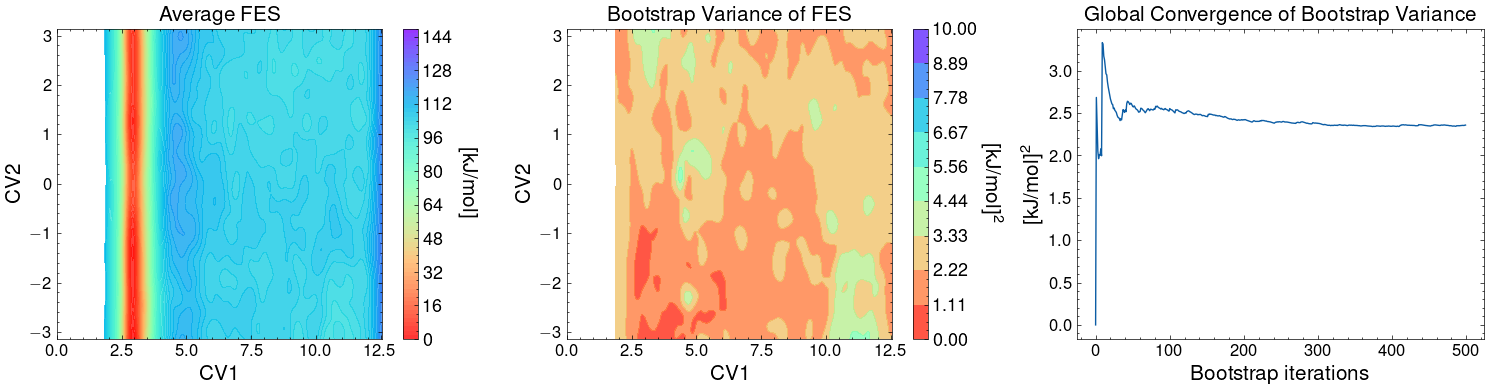

In [35]:
[FES_avr_wat_2d, sd_fes_wat_2d, sd_fes_prog_wat_2d ] = MFI.bootstrap_2D_new(X, Y, forces_all_, n_bootstrap=500, FES_cutoff=150)

MFI.plot_bootstrap(X, Y, MFI.zero_to_nan(np.where(master_patch[-1][0] > 0.1, FES_avr_wat_2d, 0)), MFI.zero_to_nan(np.where(master_patch[-1][0] > 0.1, sd_fes_wat_2d, 0)), sd_fes_prog_wat_2d, FES_lim=150, ofe_lim=10)
plt.tight_layout()
plt.savefig("free_energy_surf_betasc_wat_410K_32k.png", format="png", dpi=1200)
#plt.show()

In [2]:
#fesavgtosave = FES_avr.tolist()
#fes_avgjson = json.dump(fesavgtosave, codecs.open(str(fes_410K_wat_xtb_patch)+'fesavg_wat_wall_410.json','w', encoding = 'utf-8'))

In [ ]:
import json
import codecs

stdtosave = sd_fes_wat_2d.tolist()
sdjson = json.dump(stdtosave, codecs.open(str(fes_410K_wat_xtb_patch)+'std_wat_410.json','w', encoding = 'utf-8'))

fesavgtosave = FES_avr_wat_2d.tolist()
fes_avgjson = json.dump(fesavgtosave, codecs.open(str(fes_410K_wat_xtb_patch)+'fesavg_wat_410.json','w', encoding = 'utf-8'))

In [ ]:
f = open(str(fes_410K_wat_xtb_patch)+'fesavg_wat410.json','r')

Z_matrix_wat = np.array(json.load(f)).reshape(400,800)

var = open(str(fes_410K_wat_xtb_patch)+'std_wat410.json','r')
variance = json.load(var)

Var_wat = np.array(variance).reshape(400,800)

100 FES st. dev. = 2.058
200 FES st. dev. = 2.021
300 FES st. dev. = 1.936
400 FES st. dev. = 1.95
500 FES st. dev. = 1.928


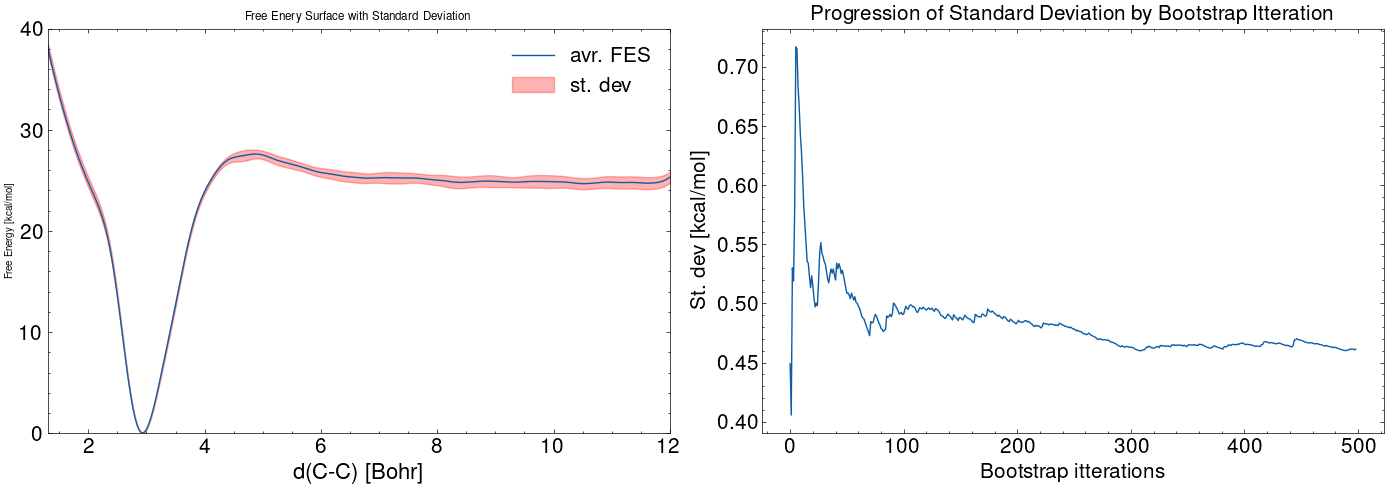

In [42]:
import importlib
importlib.reload(MFI)

X = np.linspace(0, 4*np.pi, 800)
Y = np.linspace(-np.pi, np.pi, 400)
[FES_avr_wat, cutoff, sd_fes_wat, sd_fes_prog_wat ] = MFI.bootstrap_1D_fes(X, Y, forces_all_, n_bootstrap=500, FES_cutoff=150, FFT_integration=1, min_grid = np.array((0, -np.pi)), max_grid = np.array((4*np.pi, np.pi)) )

#Plot
plt.figure(figsize=(14,5)); plt.subplot(1,2,1)
plt.plot(X,(FES_avr_wat-8)/4.18, label="avr. FES")
plt.fill_between(X, (FES_avr_wat - sd_fes_wat - 8)/4.18, (FES_avr_wat + sd_fes_wat - 8)/4.18, alpha=0.3, color="red", label="st. dev")
plt.xlabel("d(C-C)"), plt.ylabel("Free Energy [kcal/mol]"); plt.legend(fontsize=15); plt.title("Free Enery Surface with Standard Deviation")
plt.ylim([0,40])
plt.xlim([1.3,12])
plt.xlabel('d(C-C) [Bohr]', fontsize = 16)
#plt.ylabel('FES projection [kcal/mol]',fontsize = 16)
plt.xticks([2,4,6,8,10,12],["2","4","6","8","10","12"] , fontsize=15)
plt.yticks([0,10,20,30,40], ["0", "10", "20", "30","40"], fontsize=15)

plt.subplot(1,2,2)
plt.plot(range(len(sd_fes_prog_wat)), np.asarray(sd_fes_prog_wat)/4.18)
plt.xlabel("Bootstrap itterations", fontsize=15), plt.ylabel("St. dev [kcal/mol]", fontsize=15); plt.title("Progression of Standard Deviation by Bootstrap Itteration", fontsize=15); plt.tight_layout()
plt.xticks([0,100,200,300,400,500],["0", "100", "200", "300","400", "500"] , fontsize=15)
plt.yticks( fontsize=15)
#plt.legend([ 'vacuum', "Water", "nBA monomer", "Xylene" ], fontsize = 13)
plt.tight_layout()
plt.savefig("free_energy_surf_1d_betasc_wat_410K.png", format="png", dpi=1200)

In [43]:
import json
import codecs

stdtosave = sd_fes_wat.tolist()
sdjson = json.dump(stdtosave, codecs.open(str(fes_410K_wat_xtb_patch)+'std_wat410_1d.json','w', encoding = 'utf-8'))

fesavgtosave = FES_avr_wat.tolist()
fes_avgjson = json.dump(fesavgtosave, codecs.open(str(fes_410K_wat_xtb_patch)+'fesavg_wat410_1d.json','w', encoding = 'utf-8'))

In [44]:
f = open(str(fes_410K_wat_xtb_patch)+'fesavg_wat410_1d.json','r')

fes_wat_1d = np.array(json.load(f)).reshape(800)

var = open(str(fes_410K_wat_xtb_patch)+'std_wat410_1d.json','r')
variance = json.load(var)

sd_wat_1d = np.array(variance).reshape(800)

## **III)** Water Solvent @510K GNFN1 XTB 

In [ ]:
fes_410K_wat_xtb_patch =  str(path)+'Simulation Data/nButylAcrylate/BETASC/WAT/410K/'

forces_all = []
master = []
all_hills= []
error_history = []
Ftot_master = []
master_patch = [[np.zeros((400,800)), np.zeros((400,800)), np.zeros((400,800)), np.zeros((400,800)), np.zeros((400,800)), np.zeros((400,800))]]
FP = np.zeros((400,800))
ofe_history_patch = [0]
ofe_history_patch_time = [0]
X = np.linspace(0, 4*np.pi, 800)
Y = np.linspace(-np.pi, np.pi, 400)
time_history_patch = []
volume_history_patch = []
error_history =[]
dx = np.abs( X[0] - X[1] )
dy = np.abs( Y[0] - Y[1] )

In [ ]:
#metadyn2hills(sigma_x,sigma_y,gamma,hartree_2_kj, 7,8 , fes_410K_wat_xtb_patch,60)

In [ ]:
n_simulations = 8

for simulation in np.arange(1,n_simulations+1):

    HILLS=MFI.load_HILLS_2D(hills_name=str(fes_410K_wat_xtb_patch)+"HILLS_"+str(simulation))
    
    #Read the Colvar File
    [position_x, position_y] = MFI.load_position_2D(position_name=str(fes_410K_wat_xtb_patch)+"position_"+str(simulation))
    #COMPUTE Mean force and weight of the simulation
    [X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, time_history, Ftot_den2, ofv_num_x, ofv_num_y] = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw_x = 0.2, bw_y = 0.2, kT = 3.4, min_grid = np.array((0, -np.pi)), max_grid = np.array((4*np.pi, np.pi)), nbins = np.array((400,800)), log_pace = 100, error_pace = 100, base_terms=0, window_corners=[], WellTempered = 0, nhills=-1, periodic_x=0, periodic_y=1, FES_cutoff=150)

    forces_all.append([X, Y, Ftot_den, Ftot_x, Ftot_y])

    master.append([Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_y])

    master_patch.append(MFI.patch_2D(master))
    
    ofe_history_patch += ofe_history
    ofe_history_time_adj = [element+ofe_history_patch_time[-1] for element in time_history]
    ofe_history_patch_time += ofe_history_time_adj
    
forces_all_ = np.asarray(forces_all)[:,[2,3,4],:,:]

In [ ]:
[FES_avr_wat_2d, sd_fes_wat_2d, sd_fes_prog_wat_2d ] = MFI.bootstrap_2D_new(X, Y, forces_all_, n_bootstrap=500, FES_cutoff=150)

MFI.plot_bootstrap(X, Y, MFI.zero_to_nan(np.where(master_patch[-1][0] > 0.1, FES_avr_wat_2d, 0)), MFI.zero_to_nan(np.where(master_patch[-1][0] > 0.1, sd_fes_wat_2d, 0)), sd_fes_prog_wat_2d, FES_lim=150, ofe_lim=10)
plt.tight_layout()
plt.savefig("free_energy_surf_betasc_wat_410K_32k.png", format="png", dpi=1200)
#plt.show()

In [ ]:
import json
import codecs

stdtosave = sd_fes_wat_2d.tolist()
sdjson = json.dump(stdtosave, codecs.open(str(fes_410K_wat_xtb_patch)+'std_wat_410.json','w', encoding = 'utf-8'))

fesavgtosave = FES_avr_wat_2d.tolist()
fes_avgjson = json.dump(fesavgtosave, codecs.open(str(fes_410K_wat_xtb_patch)+'fesavg_wat_410.json','w', encoding = 'utf-8'))

In [ ]:
import importlib
importlib.reload(MFI)

X = np.linspace(0, 4*np.pi, 800)
Y = np.linspace(-np.pi, np.pi, 400)
[FES_avr_wat, cutoff, sd_fes_wat, sd_fes_prog_wat ] = MFI.bootstrap_1D_fes(X, Y, forces_all_, n_bootstrap=500, FES_cutoff=150, FFT_integration=1, min_grid = np.array((0, -np.pi)), max_grid = np.array((4*np.pi, np.pi)) )

#Plot
plt.figure(figsize=(14,5)); plt.subplot(1,2,1)
plt.plot(X,(FES_avr_wat-8)/4.18, label="avr. FES")
plt.fill_between(X, (FES_avr_wat - sd_fes_wat - 8)/4.18, (FES_avr_wat + sd_fes_wat - 8)/4.18, alpha=0.3, color="red", label="st. dev")
plt.xlabel("d(C-C)"), plt.ylabel("Free Energy [kcal/mol]"); plt.legend(fontsize=15); plt.title("Free Enery Surface with Standard Deviation")
plt.ylim([0,40])
plt.xlim([1.3,12])
plt.xlabel('d(C-C) [Bohr]', fontsize = 16)
plt.xticks([2,4,6,8,10,12],["2","4","6","8","10","12"] , fontsize=15)
plt.yticks([0,10,20,30,40], ["0", "10", "20", "30","40"], fontsize=15)

plt.subplot(1,2,2)
plt.plot(range(len(sd_fes_prog_wat)), np.asarray(sd_fes_prog_wat)/4.18)
plt.xlabel("Bootstrap itterations", fontsize=15), plt.ylabel("St. dev [kcal/mol]", fontsize=15); plt.title("Progression of Standard Deviation by Bootstrap Itteration", fontsize=15); plt.tight_layout()
plt.xticks([0,100,200,300,400,500],["0", "100", "200", "300","400", "500"] , fontsize=15)
plt.yticks( fontsize=15)
plt.tight_layout()
plt.savefig("free_energy_surf_1d_betasc_wat_410K.png", format="png", dpi=1200)

In [ ]:
import json
import codecs

stdtosave = sd_fes_wat.tolist()
sdjson = json.dump(stdtosave, codecs.open(str(fes_410K_wat_xtb_patch)+'std_wat410_1d.json','w', encoding = 'utf-8'))

fesavgtosave = FES_avr_wat.tolist()
fes_avgjson = json.dump(fesavgtosave, codecs.open(str(fes_410K_wat_xtb_patch)+'fesavg_wat410_1d.json','w', encoding = 'utf-8'))

In [ ]:
f = open(str(fes_410K_wat_xtb_patch)+'fesavg_wat410_1d.json','r')

fes_wat_1d = np.array(json.load(f)).reshape(800)

var = open(str(fes_410K_wat_xtb_patch)+'std_wat410_1d.json','r')
variance = json.load(var)

sd_wat_1d = np.array(variance).reshape(800)

## Postprocessing

In [50]:
import json
import codecs

#fes_310K_gas_xtb_patch = str(path)+'Simulation Data/nButylAcrylate/BETASC/GAS/410K/'
#fes_310K_gas_xtb_patch = str(path)+'Simulation Data/nButylAcrylate/BETASC/GAS/410K/'
#fes_310K_gas_xtb_patch = str(path)+'Simulation Data/nButylAcrylate/BETASC/GAS/410K/'
#fes_310K_gas_xtb_patch = str(path)+'Simulation Data/nButylAcrylate/BETASC/GAS/310K/'
#fes_310K_gas_xtb_patch = str(path)+'Simulation Data/nButylAcrylate/BETASC/GAS/510K/'
#fes_310K_gas_xtb_patch = str(path)+'Simulation Data/nButylAcrylate/BETASC/GAS/510K/'


f = open(str(fes_310K_gas_xtb_patch)+'fesavg_gas_310_1d.json','r')

fes_gas_1d_310K = np.array(json.load(f)).reshape(800)

var = open(str(fes_310K_gas_xtb_patch)+'std_gas_310_1d.json','r')
 
var_gas_1d_310K = np.array(json.load(var)).reshape(800)

f = open(str(fes_410K_gas_xtb_patch)+'fesavg_gas_410_1d.json','r')

fes_gas_1d_410K = np.array(json.load(f)).reshape(800)

var = open(str(fes_410K_gas_xtb_patch)+'std_gas_410_1d.json','r')
 
var_gas_1d_410K = np.array(json.load(var)).reshape(800)

f = open(str(fes_510K_gas_xtb_patch)+'fesavg_gas_510_1d.json','r')

fes_gas_1d_510K = np.array(json.load(f)).reshape(800)

var = open(str(fes_510K_gas_xtb_patch)+'std_gas_510_1d.json','r')
 
var_gas_1d_510K = np.array(json.load(var)).reshape(800)

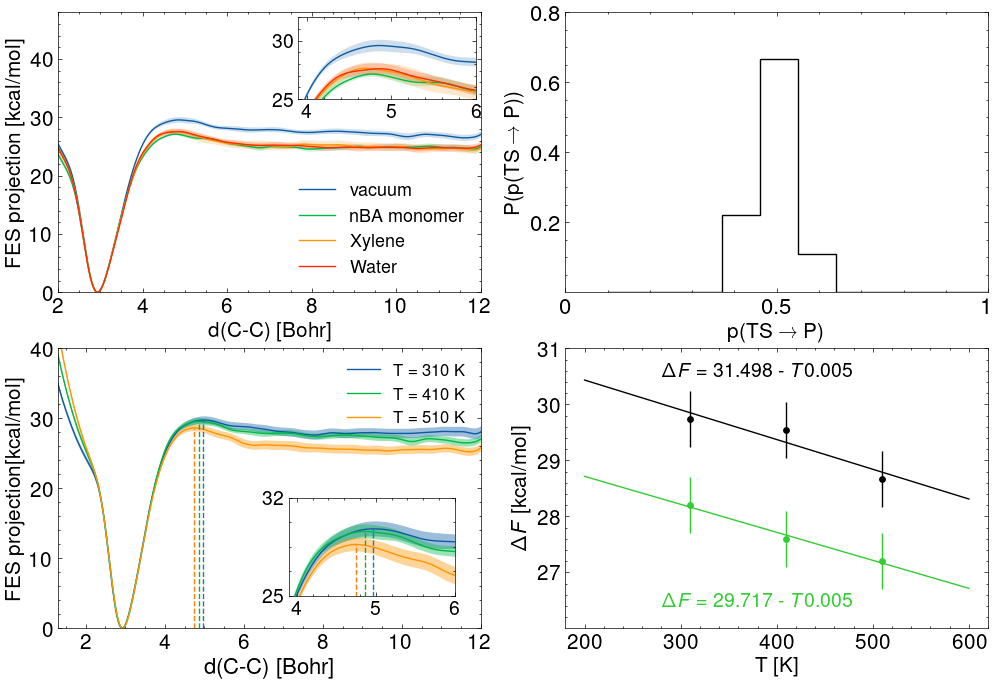

In [106]:
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

fig = plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(2,2, width_ratios=[1,1], height_ratios=[1,1])

ax0 = plt.subplot(gs[0,0])

zax0 = zoomed_inset_axes(ax0, 2, loc=1)

X = np.linspace(0, 4*np.pi, 800)
XX = np.linspace(0, 4*np.pi, 800)
fes_gas_1d = fes_gas_1d_410K
sd_gas_1d = var_gas_1d_410K
ax0.plot(XX,(fes_gas_1d - np.min(fes_gas_1d) - 8)/4.18 )
ax0.fill_between(XX, (fes_gas_1d - sd_gas_1d - np.min(fes_gas_1d) - 8)/4.18, (fes_gas_1d + sd_gas_1d - np.min(fes_gas_1d) - 8)/4.18, alpha=0.2, label='_nolegend_')
ax0.plot(X,(fes_bulk_1d-np.min(fes_bulk_1d) - 8)/4.18 )
ax0.fill_between(X, (fes_bulk_1d - sd_bulk_1d-np.min(fes_bulk_1d) - 8)/4.18, (fes_bulk_1d + sd_bulk_1d - np.min(fes_bulk_1d) - 8)/4.18, alpha=0.2, label='_nolegend_')
ax0.plot(X,(fes_xyl_1d - np.min(fes_xyl_1d) - 8)/4.18 )
ax0.fill_between(X, (fes_xyl_1d - np.min(fes_xyl_1d) - sd_xyl_1d - 8)/4.18, (fes_xyl_1d - np.min(fes_xyl_1d) + sd_xyl_1d - 8)/4.18, alpha=0.2, label='_nolegend_')
ax0.plot(X,(fes_wat_1d-np.min(fes_wat_1d) - 8)/4.18 )
ax0.fill_between(X, (fes_wat_1d - sd_wat_1d - np.min(fes_wat_1d) - 8)/4.18, (fes_wat_1d + sd_wat_1d - np.min(fes_wat_1d) - 8)/4.18, alpha=0.2,  label='_nolegend_')

ax0.set_ylim([0,48])
ax0.set_xlim([2,12])
ax0.set_xlabel('d(C-C) [Bohr]', fontsize = 15)
ax0.set_ylabel('FES projection [kcal/mol]',fontsize = 15)
ax0.set_xticks([2,4,6,8,10,12],["2","4","6","8","10","12"] , fontsize=15)
ax0.set_yticks([0,10,20,30,40], ["0", "10", "20", "30","40"], fontsize=15)
ax0.legend([ 'vacuum', "nBA monomer", "Xylene" , "Water" ], loc='lower right', fontsize = 13)


zax0.plot(XX,(fes_gas_1d - np.min(fes_gas_1d) - 8)/4.18 )
zax0.fill_between(XX, (fes_gas_1d - sd_gas_1d - np.min(fes_gas_1d) - 8)/4.18, (fes_gas_1d + sd_gas_1d - np.min(fes_gas_1d) - 8)/4.18, alpha=0.2, label='_nolegend_')
zax0.plot(X,(fes_bulk_1d-np.min(fes_bulk_1d) - 8)/4.18 )
zax0.fill_between(X, (fes_bulk_1d - sd_bulk_1d-np.min(fes_bulk_1d) - 8)/4.18, (fes_bulk_1d + sd_bulk_1d - np.min(fes_bulk_1d) - 7)/4.18, alpha=0.2, label='_nolegend_')
zax0.plot(X,(fes_xyl_1d - np.min(fes_xyl_1d) - 8)/4.18 )
zax0.fill_between(X, (fes_xyl_1d - np.min(fes_xyl_1d) - sd_xyl_1d - 8)/4.18, (fes_xyl_1d - np.min(fes_xyl_1d) + sd_xyl_1d - 8)/4.18, alpha=0.2, label='_nolegend_')
zax0.plot(X,(fes_wat_1d-np.min(fes_wat_1d) - 8)/4.18 )
zax0.fill_between(X, (fes_wat_1d - sd_wat_1d - np.min(fes_wat_1d) - 8)/4.18, (fes_wat_1d + sd_wat_1d - np.min(fes_wat_1d) - 8)/4.18, alpha=0.2,  label='_nolegend_')

zax0.set_ylim([25,32])
zax0.set_xlim([3.9,6.0])
zax0.tick_params(axis='both', labelsize=14)
zax0.set_xticks([4,5,6],["4","5","6"] , fontsize=14)

ax1 = plt.subplot(gs[0,1])

n_bins = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
prob = [0.5172413793103449,0.5517241379310345,0.6896551724137931,0.5517241379310345,0.5517241379310345,0.5172413793103449,0.41379310344827586,0.4482758620689655,0.5517241379310345]
counts = [0,0,0,2/9,6/9,1/9,0,0,0,0]
ax1.hist(n_bins, weights=counts, histtype='step', stacked=True, fill=False, color='k')
ax1.set_xlim([0,1])
ax1.set_xticks([0, 0.5, 1], ["0", "0.5", "1"], fontsize=16)
ax1.set_yticks([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"], fontsize=16)
ax1.set_ylabel("P(p(TS → P))", fontsize=15)
ax1.set_xlabel("p(TS → P)", fontsize=15)


ax2 = plt.subplot(gs[1,0])

InverseTemperature = [2.42, 2.48, 2.55, 2.61]
k_b = 1.38*1e-23
h_bar = 6.63*1e-34
R_gas = 1.987
Marien = 428
Peck = 6
RefError = [0.1, 0.15, 0.12, 0.1]
#Temperatures = [1000/420, 1000/410, 1000/400, 1000/300]
k_cucc = 10**(12.460)*np.exp(-116900/4.18/1.987/410)
width=0.3
bins = map(lambda x: x-width/2,range(1,5+1))

#ax2 = plt.subplots(gs[0,1])
#zax = zoomed_inset_axes(ax, 2, loc='center right')
# Create zoomed axes
zax = zoomed_inset_axes(ax2, 2, loc=4, bbox_to_anchor=(0.45,0.1,0.5,0.5), bbox_transform=ax2.transAxes) #

#Plot
#plt.figure(figsize=(7,5)); #plt.subplot(1,2,1)
ax2.plot(X,(fes_gas_1d_310K-np.min(fes_gas_1d_310K)-8)/4.18)
ax2.fill_between(X, (fes_gas_1d_310K - var_gas_1d_310K  - np.min(fes_gas_1d_310K)-8)/4.18, (fes_gas_1d_310K + var_gas_1d_310K  - np.min(fes_gas_1d_310K)-8)/4.18, alpha=0.4, label='_nolegend_')
ax2.plot(X,(fes_gas_1d_410K-np.min(fes_gas_1d_410K)-8)/4.18)
ax2.fill_between(X, (fes_gas_1d_410K - var_gas_1d_410K  - np.min(fes_gas_1d_410K)-8)/4.18, (fes_gas_1d_410K + var_gas_1d_410K  - np.min(fes_gas_1d_410K)-8)/4.18, alpha=0.4, label='_nolegend_')
ax2.plot(X,(fes_gas_1d_510K-np.min(fes_gas_1d_510K)-8)/4.18)
ax2.fill_between(X, (fes_gas_1d_510K - var_gas_1d_510K  - np.min(fes_gas_1d_510K)-8)/4.18, (fes_gas_1d_510K + var_gas_1d_510K  - np.min(fes_gas_1d_510K)-8)/4.18, alpha=0.4, label='_nolegend_')
idx_310K = fes_gas_1d_310K.tolist().index(np.max(fes_gas_1d_310K.tolist()[200:700]))
idx_410K = fes_gas_1d_410K.tolist().index(np.max(fes_gas_1d_410K.tolist()[200:700]))
idx_510K = fes_gas_1d_510K.tolist().index(np.max(fes_gas_1d_510K.tolist()[200:700]))
idx_min =  fes_gas_1d_510K.tolist().index(np.min(fes_gas_1d_510K.tolist()[90:700]))
#print((fes_gas_1d_310K[idx_310K]-8)/4.18, var_gas_1d_310K[idx_310K]/4.18 , (X[idx_310K]-X[idx_min]),(fes_gas_1d_410K[idx_410K]-8)/4.18, var_gas_1d_410K[idx_410K]/4.18, (X[idx_410K]-X[idx_min]),(fes_gas_1d_510K[idx_510K]-8)/4.18, var_gas_1d_510K[idx_510K]/4.18, (X[idx_510K]-X[idx_min]) )
ax2.plot([X[idx_310K], X[idx_310K]], [np.min(fes_gas_1d_310K),(fes_gas_1d_310K[idx_310K]-8)/4.18], color='#1f77b4', linestyle='dashed')
ax2.plot([X[idx_410K], X[idx_410K]], [np.min(fes_gas_1d_410K),(fes_gas_1d_410K[idx_410K]-8)/4.18], color='#2ca02c', linestyle='dashed')
ax2.plot([X[idx_510K], X[idx_510K]], [np.min(fes_gas_1d_510K),(fes_gas_1d_510K[idx_510K]-8)/4.18], color='#ff7f0e', linestyle='dashed')

ax2.set_xlabel("d(C-C)"), ax2.set_ylabel("FES projection[kcal/mol]", fontsize=15); #plt.title("Temperature trend", fontsize=15)
ax2.set_ylim([0,40])
ax2.set_xlim([1.3,12])
ax2.set_xlabel('d(C-C) [Bohr]', fontsize = 16)
ax2.set_xticks([2,4,6,8,10,12],["2","4","6","8","10","12"] , fontsize=15)
ax2.set_yticks([0,10,20,30,40], ["0", "10", "20", "30","40"], fontsize=15)
ax2.legend([ "T = 310 K", "T = 410 K", "T = 510 K" ], loc='upper right', fontsize = 12)

zax.plot(X,(fes_gas_1d_310K-np.min(fes_gas_1d_310K)-8)/4.18)
zax.fill_between(X, (fes_gas_1d_310K - var_gas_1d_310K  - np.min(fes_gas_1d_310K)-8)/4.18, (fes_gas_1d_310K + var_gas_1d_310K  - np.min(fes_gas_1d_310K)-8)/4.18, alpha=0.4)
zax.plot(X,(fes_gas_1d_410K-np.min(fes_gas_1d_410K)-8)/4.18)
zax.fill_between(X, (fes_gas_1d_410K - var_gas_1d_410K  - np.min(fes_gas_1d_410K)-8)/4.18, (fes_gas_1d_410K + var_gas_1d_410K  - np.min(fes_gas_1d_410K)-8)/4.18, alpha=0.4)
zax.plot(X,(fes_gas_1d_510K-np.min(fes_gas_1d_510K)-8)/4.18)
zax.fill_between(X, (fes_gas_1d_510K - var_gas_1d_510K  - np.min(fes_gas_1d_510K)-8)/4.18, (fes_gas_1d_510K + var_gas_1d_510K  - np.min(fes_gas_1d_510K)-8)/4.18, alpha=0.4)
zax.plot([X[idx_310K], X[idx_310K]], [np.min(fes_gas_1d_310K),(fes_gas_1d_310K[idx_310K]-8)/4.18], color='#1f77b4', linestyle='dashed')
zax.plot([X[idx_410K], X[idx_410K]], [np.min(fes_gas_1d_410K),(fes_gas_1d_410K[idx_410K]-8)/4.18], color='#2ca02c', linestyle='dashed')
zax.plot([X[idx_510K], X[idx_510K]], [np.min(fes_gas_1d_510K),(fes_gas_1d_510K[idx_510K]-8)/4.18], color='#ff7f0e', linestyle='dashed')
zax.set_ylim([25,32])
zax.set_xlim([3.9,6.0])
zax.set_xticks([4,5,6],["4","5","6"] , fontsize=14)
zax.set_yticks([25,32], ["25", "32"], fontsize=14)
zax.tick_params(axis='both', labelsize=14)

#ax2.legend(['Marien et al.', 'Peck, Hutchinson', 'Rare Events(xyl)', 'Rare Events(gas)', 'Cuccato et al.(gas)'], fontsize = 12, frameon=False, ncol = 1)

ax3 = plt.subplot(gs[1,1])

from sklearn.linear_model import LinearRegression

DF = np.array([29.739706, 29.5456224491, 28.6775698952])
DFw = np.array([28.2, 27.6, 27.2])
T = np.array([310,410,510]).reshape((-1,1))
std = np.array([0.5,0.5,0.5])
temperature = np.linspace(200,600,1000).reshape((-1,1))

line = LinearRegression().fit(T,DF)
DS = line.coef_
DH = line.intercept_

line_w = LinearRegression().fit(T,DFw)
DSw = line_w.coef_
DHw = line_w.intercept_

DS = DS[0].round(3)
DH = DH.round(3)
DSw = DSw[0].round(3)
DHw = DHw.round(3)

ax3.scatter(T, DF, s=15, color='k')
ax3.errorbar(T,DF,yerr=std, color='k', fmt='o')
ax3.plot(temperature,line.predict(temperature), color='k',label='gas')
ax3.scatter(T, DFw, s=15,color='limegreen')
ax3.errorbar(T,DFw,yerr=std, fmt='o', color='limegreen')
ax3.plot(temperature,line_w.predict(temperature), color='limegreen', label='water')
ax3.set_ylim(26,31)
ax3.text(280,30.5,'$\Delta F $ = '+str(DH)+' - $ T $'+str(-DS), fontsize=14)
ax3.text(280,26.4,'$\Delta F $ = '+str(DHw)+' - $ T $'+str(-DSw), fontsize=14, color='limegreen')
ax3.set_xlabel("T [K]", fontsize=15), ax3.set_ylabel(" $\Delta F$ [kcal/mol]", fontsize=15); #plt.tight_layout()
ax3.set_xticks([200,300,400,500,600],["200", "300", "400", "500", "600"] , fontsize=15)
ax3.set_yticks([27,28,29,30,31],["27","28", "29", "30", "31"] , fontsize=15)
#ax3.set_yticks(fontsize=15)
#plt.tight_layout()
plt.savefig("plots_combined_4.png", format="png", dpi=1200)


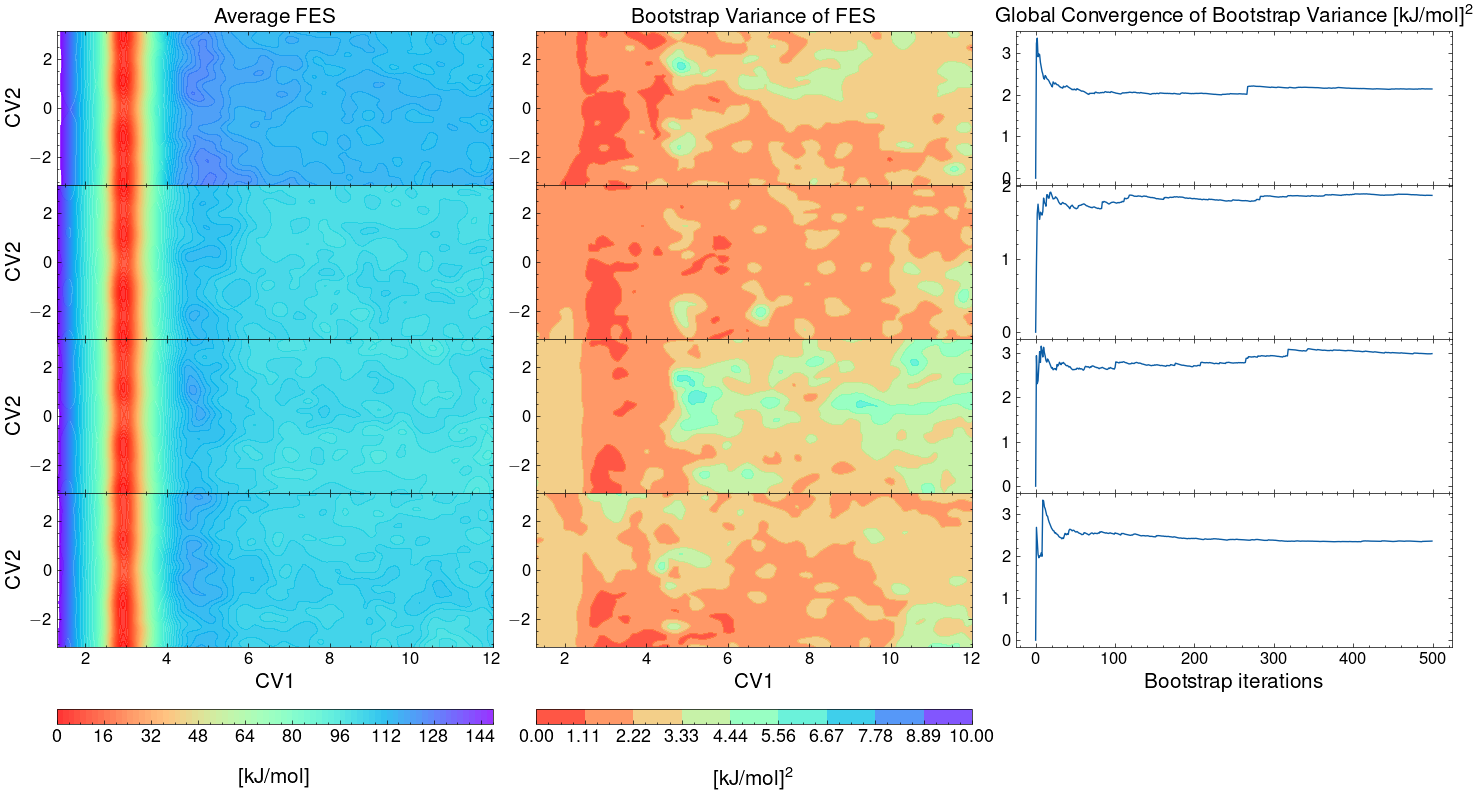

In [40]:
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FormatStrFormatter

fig = plt.figure(figsize=(18,9))
gs = gridspec.GridSpec(6,3, width_ratios=[1,1,1], height_ratios=[1,1,1,1,0.4,0.1])

FES_lim=150
ofe_lim=10

# gas
ax0 = plt.subplot(gs[0,0])
cp0 = ax0.contourf(X, Y, FES_avr_gas_2d, levels=range(0, FES_lim, 2), cmap='rainbow_r', antialiased=False, alpha=0.8);
ax0.set_xlim([1.3,12])
ax0.set_ylabel('CV2', fontsize=15)
ax0.set_xlabel('CV1', fontsize=15)
ax0.set_title('Average FES', fontsize=15)
ax0.tick_params(axis='x', which='major', labelsize=0)
ax0.tick_params(axis='y', which='major', labelsize=12)

# projection (X)
ax1 = plt.subplot(gs[1,0])
cp = ax1.contourf(X, Y, FES_avr_bulk_2d, levels=range(0, FES_lim, 2), cmap='rainbow_r', antialiased=False, alpha=0.8);
ax1.set_ylabel('CV2', fontsize=15)
ax1.set_xlim([1.3,12])
ax1.tick_params(axis='x', which='major', labelsize=0)
ax1.tick_params(axis='y', which='major', labelsize=12)

# Main contour plot
ax2 = plt.subplot(gs[2,0])
cp = ax2.contourf(X, Y, FES_avr_xyl_2d, levels=range(0, FES_lim, 2), cmap='rainbow_r', antialiased=False, alpha=0.8);

ax2.set_ylabel('CV2', fontsize=15)
ax2.set_xlim([1.3,12])
ax2.tick_params(axis='x', which='major', labelsize=0)
ax2.tick_params(axis='y', which='major', labelsize=12)

# bulk
# projection (X) 
ax3 = plt.subplot(gs[3,0])
cp = ax3.contourf(X, Y, FES_avr_wat_2d, levels=range(0, FES_lim, 2), cmap='rainbow_r', antialiased=False, alpha=0.8);
ax3.set_xlim([1.3,12])

ax3.set_ylabel('CV2', fontsize=15)
ax3.set_xlabel('CV1', fontsize=15)
ax3.tick_params(axis='both', which='major', labelsize=12)


ax4 = plt.subplot(gs[0,1])
cp4 = ax4.contourf(X, Y, sd_fes_gas_2d, levels=np.linspace(0, ofe_lim, 10), cmap='rainbow_r', antialiased=False, alpha=0.8);
ax4.set_xlim([1.3,12])
ax4.set_xlabel('CV1', fontsize=15)
ax4.set_title('Bootstrap Variance of FES', fontsize=15)
ax4.tick_params(axis='x', which='major', labelsize=0)
ax4.tick_params(axis='y', which='major', labelsize=12)

ax5 = plt.subplot(gs[1,1])
cp = ax5.contourf(X, Y, sd_fes_bulk_2d, levels=np.linspace(0, ofe_lim, 10), cmap='rainbow_r', antialiased=False, alpha=0.8);
ax5.set_xlim([1.3,12])
ax5.tick_params(axis='x', which='major', labelsize=0)
ax5.tick_params(axis='y', which='major', labelsize=12)

ax6 = plt.subplot(gs[2,1])
cp = ax6.contourf(X, Y, sd_fes_xyl_2d, levels=np.linspace(0, ofe_lim, 10), cmap='rainbow_r', antialiased=False, alpha=0.8);
ax6.set_xlim([1.3,12])
ax6.tick_params(axis='x', which='major', labelsize=0)
ax6.tick_params(axis='y', which='major', labelsize=12)

ax7 = plt.subplot(gs[3,1])
cp = ax7.contourf(X, Y, sd_fes_wat_2d, levels=np.linspace(0, ofe_lim, 10), cmap='rainbow_r', antialiased=False, alpha=0.8);
ax7.set_xlim([1.3,12])
ax7.set_xlabel('CV1', fontsize=15)
ax7.tick_params(axis='both', which='major', labelsize=12)

ax8 = plt.subplot(gs[0,2])
ax8.plot( range(len(sd_fes_prog_gas_2d)), sd_fes_prog_gas_2d);
ax8.set_xlabel('Bootstrap iterations', fontsize=15)
ax8.set_title('Global Convergence of Bootstrap Variance [kJ/mol]$^2$', fontsize=15)
ax8.tick_params(axis='x', which='major', labelsize=0)
ax8.tick_params(axis='y', which='major', labelsize=12)

ax9 = plt.subplot(gs[1,2])
ax9.plot( range(len(sd_fes_prog_bulk_2d)), sd_fes_prog_bulk_2d);
ax9.tick_params(axis='x', which='major', labelsize=0)
ax9.tick_params(axis='y', which='major', labelsize=12)

ax10 = plt.subplot(gs[2,2])
ax10.plot( range(len(sd_fes_prog_xyl_2d)), sd_fes_prog_xyl_2d);
ax10.tick_params(axis='x', which='major', labelsize=0)
ax10.tick_params(axis='y', which='major', labelsize=12)

ax11 = plt.subplot(gs[3,2])
ax11.plot( range(len(sd_fes_prog_wat_2d)), sd_fes_prog_wat_2d);
ax11.set_xlabel('Bootstrap iterations', fontsize=15)
ax11.tick_params(axis='both', which='major', labelsize=12)

# Colorbar
axc0 = plt.subplot(gs[5, 0])
cbar = plt.colorbar(cp0, cax=axc0, orientation='horizontal')
cbar.ax.tick_params(labelsize=13)
cbar.set_label("[kJ/mol]", rotation=0,labelpad=17, fontsize=15)


## Colorbar
axc1 = plt.subplot(gs[5, 1])
cbar = plt.colorbar(cp4, cax=axc1, orientation='horizontal')
cbar.set_label("[kJ/mol]$^2$", rotation=0,labelpad=17, fontsize=15)
cbar.ax.tick_params(labelsize=13)

plt.subplots_adjust(wspace=0.1, hspace=0)
plt.savefig("SupplementaryData_2d.png", format="png", dpi=600)
#plt.show()

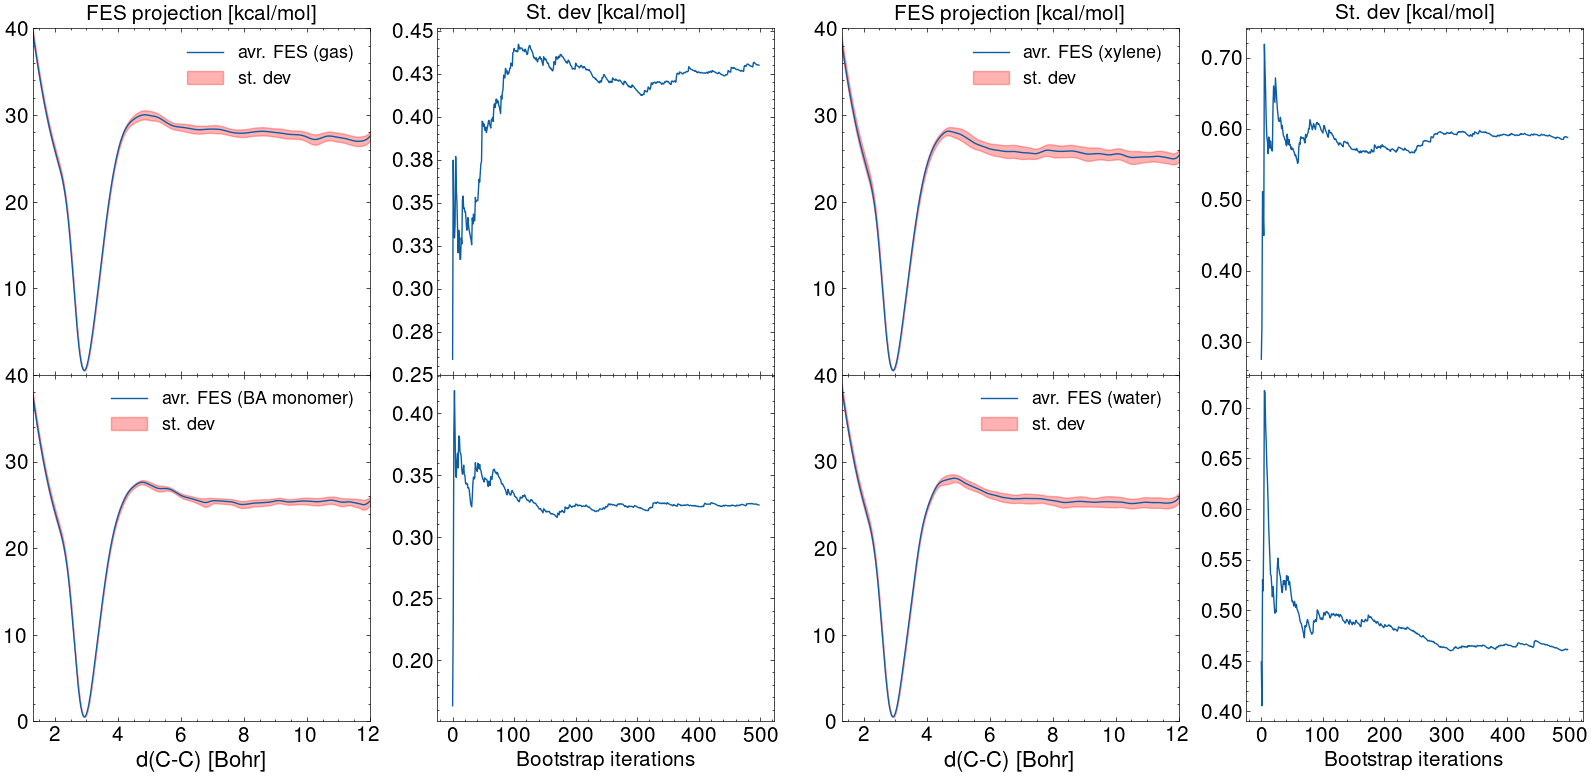

In [54]:
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FormatStrFormatter

Y = np.linspace(-np.pi, np.pi, 400)

fig = plt.figure(figsize=(20,9))
gs = gridspec.GridSpec(2, 4, width_ratios=[1,1,1,1], height_ratios=[1,1])
FES_avr_gas = fes_gas_1d
sd_fes_gas = sd_gas_1d
sd_fes_prog_gas = sdprog_gas_1d
# gas
ax0 = plt.subplot(gs[0, 0])
plt.plot(X,(FES_avr_gas-np.min(FES_avr_gas)-6)/4.18, label="avr. FES (gas)")
plt.fill_between(X, (FES_avr_gas - sd_fes_gas - np.min(FES_avr_gas)-6)/4.18, (FES_avr_gas + sd_fes_gas - np.min(FES_avr_gas)-6)/4.18, alpha=0.3, color="red", label="st. dev")
#plt.xlabel("d(C-C)"), plt.ylabel("Free Energy [kcal/mol]", fontsize=15); 
plt.legend(fontsize = 13); #
plt.title("FES projection [kcal/mol]", fontsize=15)
plt.ylim([0,40])
plt.xlim([1.3,12])
plt.xticks(fontsize=0)
plt.yticks([10,20,30,40], ["10", "20", "30","40"],fontsize=15)
#plt.xlabel('d(C-C) [Bohr]', fontsize = 16)
#plt.ylabel('FES projection [kcal/mol]',fontsize = 16)

# projection (X)
ax1 = plt.subplot(gs[1, 0], sharex=ax0)
plt.plot(X,(FES_avr_bulk-np.min(FES_avr_bulk)-6)/4.18, label="avr. FES (BA monomer)")
plt.fill_between(X, (FES_avr_bulk - sd_fes_bulk - np.min(FES_avr_bulk)-6)/4.18, (FES_avr_bulk + sd_fes_bulk - np.min(FES_avr_bulk)-6)/4.18, alpha=0.3, color="red", label="st. dev")
plt.legend(fontsize = 13); 
plt.ylim([0,40])
plt.xlim([1.3,12])
plt.xticks(fontsize=15)
plt.yticks([0,10,20,30,40], ["0", "10", "20", "30","40"],fontsize=15)
plt.xlabel('d(C-C) [Bohr]', fontsize = 16)

# Main contour plot
ax2 = plt.subplot(gs[0, 2], sharex=ax0)
plt.plot(X,(FES_avr_xyl-np.min(FES_avr_xyl)-6)/4.18, label="avr. FES (xylene)")
plt.fill_between(X, (FES_avr_xyl - sd_fes_xyl - np.min(FES_avr_xyl)-6)/4.18, (FES_avr_xyl + sd_fes_xyl - np.min(FES_avr_xyl)-6)/4.18, alpha=0.3, color="red", label="st. dev")
plt.xlabel("d(C-C)")  
plt.legend(fontsize = 13)
plt.title("FES projection [kcal/mol]", fontsize=15)
plt.ylim([0,40])
plt.xlim([1.3,12])
plt.xticks(fontsize=0)
plt.yticks([10,20,30,40], ["10", "20", "30","40"],fontsize=15)

# bulk
# projection (X) 
ax3 = plt.subplot(gs[1, 2], sharex=ax0)
plt.plot(X,(FES_avr_wat-np.min(FES_avr_wat)-6)/4.18, label="avr. FES (water)")
plt.fill_between(X, (FES_avr_wat - sd_fes_wat - np.min(FES_avr_wat)-6)/4.18, (FES_avr_wat + sd_fes_wat - np.min(FES_avr_wat)-6)/4.18, alpha=0.3, color="red", label="st. dev")
plt.legend(fontsize = 13); 
plt.ylim([0,40])
plt.xlim([1.3,12])
plt.xlabel('d(C-C) [Bohr]', fontsize = 16)
plt.xticks([2,4,6,8,10,12],["2","4","6","8","10","12"] , fontsize=15)
plt.yticks([0,10,20,30,40], ["0", "10", "20", "30","40"], fontsize=15)

# projection (X)
ax4 = plt.subplot(gs[0, 1])
plt.plot(range(len(sd_fes_prog_gas)), np.asarray(sd_fes_prog_gas)/4.18)
plt.title("St. dev [kcal/mol]", fontsize=15); 
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.yticks(fontsize=15)

# projection (X)
ax5 = plt.subplot(gs[1, 1], sharex=ax4)
plt.plot(range(len(sd_fes_prog_bulk)), np.asarray(sd_fes_prog_bulk)/4.18)
plt.xlabel("Bootstrap iterations", fontsize=15) 
plt.xticks([0,100,200,300,400,500],["0", "100", "200", "300","400", "500"] , fontsize=15)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.yticks(fontsize=15)

# projection (X)
ax6 = plt.subplot(gs[0, 3], sharex=ax4)
plt.plot(range(len(sd_fes_prog_xyl)), np.asarray(sd_fes_prog_xyl)/4.18)
plt.title("St. dev [kcal/mol]", fontsize=15); 
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#ax6.xticks([0,100,200,300,400,500],["0", "100", "200", "300","400", "500"] , fontsize=15)
plt.yticks(fontsize=15)

# projection (X)
ax7 = plt.subplot(gs[1, 3], sharex=ax4)
plt.plot(range(len(sd_fes_prog_wat)), np.asarray(sd_fes_prog_wat)/4.18)
plt.xlabel("Bootstrap iterations", fontsize=15)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.xticks([0,100,200,300,400,500],["0", "100", "200", "300","400", "500"] , fontsize=15)
plt.yticks(fontsize=15)

plt.subplots_adjust(wspace=0.2,  hspace=0)

plt.savefig("SupplementaryData_marginal.png", format="png", dpi=1200)
plt.show()

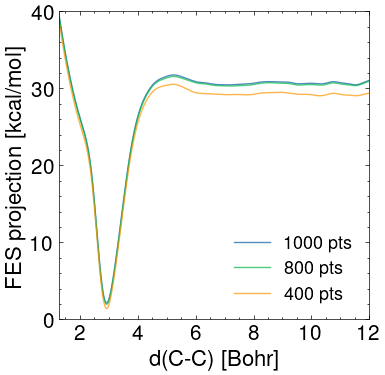

In [40]:
X = np.linspace(0, 4*np.pi, 800)
XX = np.linspace(0, 4*np.pi, 400)
XXX = np.linspace(0, 4*np.pi, 1000)

fig = plt.figure(figsize=(4, 4))
plt.axis([None, None, 0, None])

pbd_390 = np.exp(-Z_matrix_gas_high/3.4)
pbd_390 /=pbd_390.sum()
pbd_x_390 = pbd_390.sum(axis=0)
fes_1d_new = -3.4*np.log(pbd_x_390)
plt.plot(XXX,(fes_1d_new)/4.18, alpha=0.7)

pbd = np.exp(-Z_matrix_gas_medium/3.4)
pbd /=pbd.sum()
pbd_x = pbd.sum(axis=0)
fes_1d = -3.4*np.log(pbd_x)
#x,y = np.meshgrid(X,Y)
#plt.contourf(x,y,pbd)
var = Var_gas
sd_x = np.sqrt(var.sum(axis=0))
sd_x = sd_x/6.28
plt.plot(X,(fes_1d)/4.18,alpha=0.7)
#plt.fill_between(X,(fes_1d-9-sd_x)/4.18,(fes_1d-9+sd_x)/4.18,alpha=0.2, label='_nolegend_')

pbd_390 = np.exp(-Z_matrix_gas_low/3.4)
pbd_390 /=pbd_390.sum()
pbd_x_390 = pbd_390.sum(axis=0)
fes_1d_390 = -3.4*np.log(pbd_x_390)
plt.plot(XX,(fes_1d_390)/4.18, alpha=0.7)

plt.ylim([0,40])
plt.xlim([1.3,12])
plt.xlabel('d(C-C) [Bohr]', fontsize = 14)
plt.ylabel('FES projection [kcal/mol]',fontsize = 14)
plt.xticks([2,4,6,8,10,12],["2","4","6","8","10","12"] , fontsize=15)
plt.yticks([0,10,20,30,40], ["0", "10", "20", "30","40"], fontsize=15)
plt.legend(['1000 pts', '800 pts',"400 pts" ], fontsize = 13)

plt.savefig("free_energy_prof_SensitivityPoints.png", format="png", dpi=1200)

## Backbiting

## GAS

### 410 K

In [16]:
#from pyMFI import MFI

fes_410K_bckbt_xtb_patch = 'C:/Users/fserse/Desktop/PhD_Thesis/MFI/nba/BCKBT/410K/'

forces_all = []
master = []
all_hills= []
error_history = []
Ftot_master = []
master_patch = [[np.zeros((250,500)), np.zeros((250,500)), np.zeros((250,500)), np.zeros((250,500)), np.zeros((250,500)), np.zeros((250,500))]]
FP = np.zeros((250,500))
ofe_history_patch = [0]
ofe_history_patch_time = [0]
X = np.linspace(0, 4*np.pi, 500)
Y = np.linspace(-np.pi, np.pi, 250)

dx = np.abs( X[0] - X[1] )
dy = np.abs( Y[0] - Y[1] )

In [95]:
#metadyn2hills(sigma_x,sigma_y,gamma,hartree_2_kj, 12, 13, fes_410K_bckbt_xtb_patch)

|**************************************************| 100% | Bootstrap Average Standard Deviation: 4.683

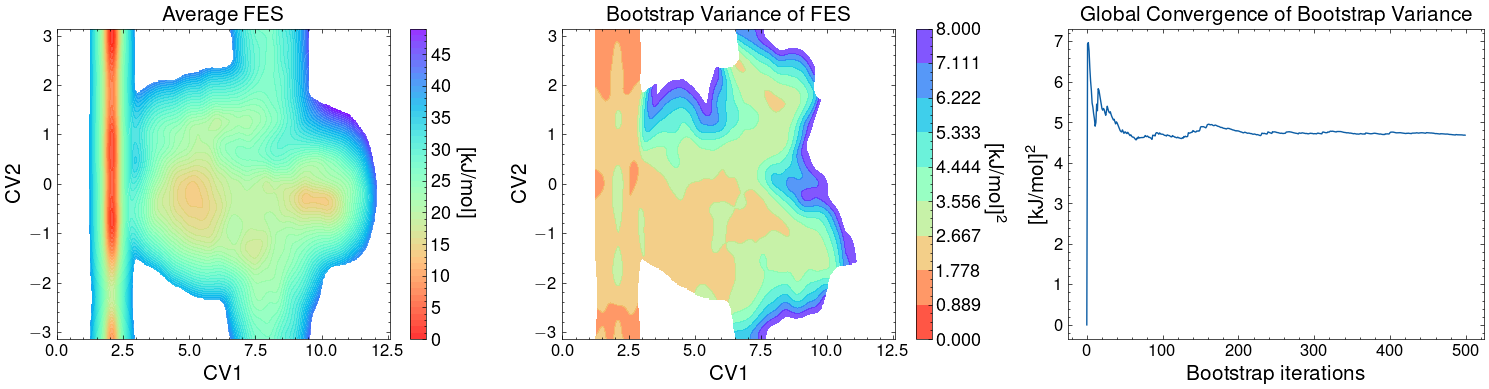

In [33]:
n_simulations = 14

for simulation in np.arange(1,n_simulations):

    HILLS=MFI.load_HILLS_2D(hills_name=str(fes_410K_bckbt_xtb_patch)+"HILLS_"+str(simulation))
    
    #Read the Colvar File
    [position_x, position_y] = MFI.load_position_2D(position_name=str(fes_410K_bckbt_xtb_patch)+"position_"+str(simulation))
    #COMPUTE Mean force and weight of the simulation
    [X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, time_history, Ftot_den2, ofv_num_x, ofv_num_y] = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw_x = 0.2, bw_y = 0.3, kT = 3.4, min_grid = np.array((0, -np.pi)), max_grid = np.array((4*np.pi, np.pi)), nbins = np.array((250,500)), log_pace = 100, error_pace = 100, base_terms=0, window_corners=[], WellTempered = 0, nhills=-1, periodic_x=0, periodic_y=1, FES_cutoff=50)

    forces_all.append([X, Y, Ftot_den, Ftot_x, Ftot_y])

    master.append([Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_y])

    master_patch.append(MFI.patch_2D(master))
    
    ofe_history_patch += ofe_history
    ofe_history_time_adj = [element+ofe_history_patch_time[-1] for element in time_history]
    ofe_history_patch_time += ofe_history_time_adj
    
    
forces_all_ = np.asarray(forces_all)[:,[2,3,4],:,:]

[FES_avr, sd_fes, sd_fes_prog ] = MFI.bootstrap_2D_new(X, Y, forces_all_, n_bootstrap=500, FES_cutoff=50)

MFI.plot_bootstrap(X, Y, MFI.zero_to_nan(np.where(master_patch[-1][0] > 0.1, FES_avr, 0)), MFI.zero_to_nan(np.where(master_patch[-1][0] > 0.1, sd_fes, 0)), sd_fes_prog, FES_lim=50, ofe_lim=8)
plt.tight_layout()
#plt.show()
plt.savefig("free_energy_surf_bckbt_410K.png", format="png", dpi=1200)

In [34]:
import json
import codecs

stdtosave = sd_fes.tolist()
sdjson = json.dump(stdtosave, codecs.open(str(fes_410K_bckbt_xtb_patch)+'std_bckbt410.json','w', encoding = 'utf-8'))

fesavgtosave = FES_avr.tolist()
fes_avgjson = json.dump(fesavgtosave, codecs.open(str(fes_410K_bckbt_xtb_patch)+'fesavg_bckbt410.json','w', encoding = 'utf-8'))

In [17]:
f = open(str(fes_410K_bckbt_xtb_patch)+'fesavg_bckbt410.json','r')

Z_matrix_bckbt_410 = np.array(json.load(f)).reshape(250,500)

var = open(str(fes_410K_bckbt_xtb_patch)+'std_bckbt410.json','r')
variance = json.load(var)

Var_bckbt_410 = np.array(variance).reshape(250,500)

## 310K

In [25]:
import os
import numpy as np
import json
os.chdir("C:/Users/fserse/Desktop/PhD_Thesis/MFI")
from pyMFI import MFI

fes_310K_bckbt_xtb_patch = 'C:/Users/fserse/Desktop/PhD_Thesis/MFI/nba/BCKBT/310K/'

forces_all = []
master = []
all_hills= []
error_history = []
Ftot_master = []
master_patch = [[np.zeros((250,500)), np.zeros((250,500)), np.zeros((250,500)), np.zeros((250,500)), np.zeros((250,500)), np.zeros((250,500))]]
FP = np.zeros((250,500))
ofe_history_patch = [0]
ofe_history_patch_time = [0]
X = np.linspace(0, 4*np.pi, 500)
Y = np.linspace(-np.pi, np.pi, 250)

In [26]:
#metadyn2hills(sigma_x,sigma_y,gamma,hartree_2_kj, 13, 14, fes_310K_bckbt_xtb_patch)

|**************************************************| 100% | Bootstrap Average Standard Deviation: 4.589

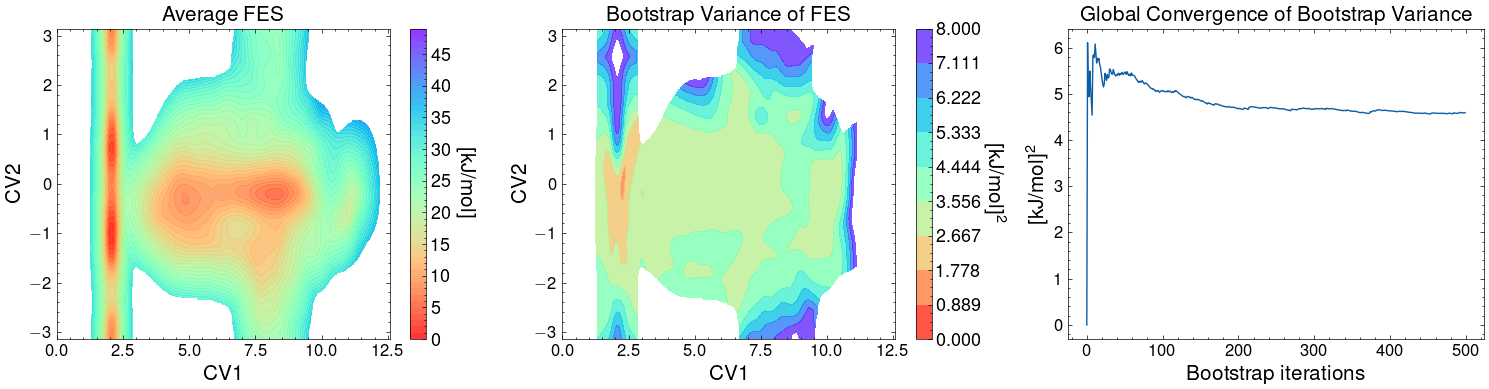

In [27]:
n_simulations = 15

for simulation in np.arange(1,n_simulations):

    HILLS=MFI.load_HILLS_2D(hills_name=str(fes_310K_bckbt_xtb_patch)+"HILLS_"+str(simulation))
    
    #Read the Colvar File
    [position_x, position_y] = MFI.load_position_2D(position_name=str(fes_310K_bckbt_xtb_patch)+"position_"+str(simulation))
    #COMPUTE Mean force and weight of the simulation
    [X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, time_history, Ftot_den2, ofv_num_x, ofv_num_y] = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw_x = 0.2, bw_y = 0.3, kT = 2.58, min_grid = np.array((0, -np.pi)), max_grid = np.array((4*np.pi, np.pi)), nbins = np.array((250,500)), log_pace = 100, error_pace = 100, base_terms=0, window_corners=[], WellTempered = 0, nhills=-1, periodic_x=0, periodic_y=1, FES_cutoff=50)

    forces_all.append([X, Y, Ftot_den, Ftot_x, Ftot_y])

    master.append([Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_y])

    master_patch.append(MFI.patch_2D(master))
    
    ofe_history_patch += ofe_history
    ofe_history_time_adj = [element+ofe_history_patch_time[-1] for element in time_history]
    ofe_history_patch_time += ofe_history_time_adj
    
    
forces_all_ = np.asarray(forces_all)[:,[2,3,4],:,:]

[FES_avr, sd_fes, sd_fes_prog ] = MFI.bootstrap_2D_new(X, Y, forces_all_, n_bootstrap=500, FES_cutoff=50)

MFI.plot_bootstrap(X, Y, MFI.zero_to_nan(np.where(master_patch[-1][0] > 0.1, FES_avr, 0)), MFI.zero_to_nan(np.where(master_patch[-1][0] > 0.1, sd_fes, 0)), sd_fes_prog, FES_lim=50, ofe_lim=8)
plt.tight_layout()
#plt.show()
plt.savefig("free_energy_surf_bckbt_310K.png", format="png", dpi=1200)

In [28]:
import json
import codecs

stdtosave = sd_fes.tolist()
sdjson = json.dump(stdtosave, codecs.open(str(fes_310K_bckbt_xtb_patch)+'std_bckbt310.json','w', encoding = 'utf-8'))

fesavgtosave = FES_avr.tolist()
fes_avgjson = json.dump(fesavgtosave, codecs.open(str(fes_310K_bckbt_xtb_patch)+'fesavg_bckbt310.json','w', encoding = 'utf-8'))

In [30]:
f = open(str(fes_310K_bckbt_xtb_patch)+'fesavg_bckbt310.json','r')

Z_matrix_bckbt_310 = np.array(json.load(f)).reshape(250,500)

var = open(str(fes_310K_bckbt_xtb_patch)+'std_bckbt310.json','r')
variance = json.load(var)

Var_bckbt_310 = np.array(variance).reshape(250,500)

0.8814087605261944


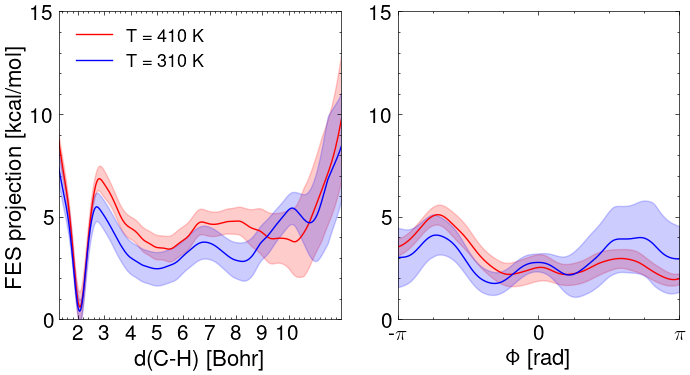

In [42]:
X = np.linspace(0, 4*np.pi, 500)
Y = np.linspace(-np.pi, np.pi, 250)

XX = np.linspace(0, 4*np.pi, 500)
YY = np.linspace(-np.pi, np.pi, 250)

print(X[35])

fig, ax = plt.subplots(1,2,figsize=(8, 4))
plt.axis([None, None, 0, None])
#zax = zoomed_inset_axes(ax, 2, loc=1)

ax = plt.subplot(1,2,1)
ax.plot(X,Z_matrix_bckbt_410[101,:]/4.18,color = "red" )
ax.fill_between(X, (Z_matrix_bckbt_410[101,:] - Var_bckbt_410[101,:])/4.18, (Z_matrix_bckbt_410[101,:] + Var_bckbt_410[101,:])/4.18, alpha=0.2, color = "red", label='_nolegend_')
ax.plot(XX,(Z_matrix_bckbt_310[91,:])/4.18,color = "blue" )
ax.fill_between(XX, (Z_matrix_bckbt_310[91,:] - Var_bckbt_310[91,:])/4.18, (Z_matrix_bckbt_310[91,:] + Var_bckbt_310[91,:])/4.18, alpha=0.2, color = "blue", label='_nolegend_')
ax.set_ylim([0,15])
ax.set_xlim([1.3,12])
ax.set_xlabel('d(C-H) [Bohr]', fontsize = 16)
ax.set_ylabel('FES projection [kcal/mol]',fontsize = 16)
ax.set_xticks([2,3,4,5,6,7,8,9,10],["2","3","4","5","6","7","8","9","10"] , fontsize=15)
ax.set_yticks([0,5,10,15], ["0", "5", "10","15"], fontsize=15)
ax.legend([ 'T = 410 K', "T = 310 K" ], fontsize = 13, loc= 'upper left')

ax = plt.subplot(1,2,2)
ax.plot(Y,Z_matrix_bckbt_410[:,75]/4.18,color = "red" )
ax.fill_between(Y, (Z_matrix_bckbt_410[:,75] - Var_bckbt_410[:,75])/4.18, (Z_matrix_bckbt_410[:,75] + Var_bckbt_410[:,75])/4.18, alpha=0.2, color = "red", label='_nolegend_')
ax.plot(YY,Z_matrix_bckbt_310[:,75]/4.18,color = "blue" )
ax.fill_between(YY, (Z_matrix_bckbt_310[:,75] - Var_bckbt_310[:,75])/4.18, (Z_matrix_bckbt_310[:,75] + Var_bckbt_310[:,75])/4.18, alpha=0.2, color = "blue", label='_nolegend_')
ax.set_ylim([0,15])
ax.set_xlim([-np.pi,np.pi])
ax.set_xlabel(' $ \Phi $ [rad]', fontsize = 16)
#ax.set_ylabel('FES projection [kcal/mol]',fontsize = 13)
ax.set_xticks([-np.pi,0,np.pi], ["-$ \pi $", "0", "$ \pi $"], fontsize=15)
ax.set_yticks([0,5,10, 15], ["0", "5", "10", "15"], fontsize=15)
#ax.legend([ 'vacuum', "nBA monomer" ], fontsize = 13)
plt.savefig("free_energy_profiles_ba_bckbt_temp.png", format="png", dpi=1200)

## Xylene

### 410 K

In [47]:
fes_410K_xyl_bckbt_xtb_patch = 'C:\\Users\\fserse\\Desktop\\PhD_Thesis\\Kinetics from Metadynamics\\Simulation Data\\nButylAcrylate\\BCKBT\\XYL\\410K\\'

forces_all = []
master = []
all_hills= []
error_history = []
Ftot_master = []
master_patch = [[np.zeros((200,400)), np.zeros((200,400)), np.zeros((200,400)), np.zeros((200,400)), np.zeros((200,400)), np.zeros((200,400))]]
FP = np.zeros((200,400))
ofe_history_patch = [0]
ofe_history_patch_time = [0]
X = np.linspace(0, 4*np.pi, 400)
Y = np.linspace(-np.pi, np.pi, 200)

dx = np.abs( X[0] - X[1] )
dy = np.abs( Y[0] - Y[1] )

In [10]:
#metadyn2hills(sigma_x,sigma_y,gamma,hartree_2_kj, 11, 15, fes_410K_xyl_bckbt_xtb_patch,90)

|**************************************************| 100% | Bootstrap Average Standard Deviation: 3.418

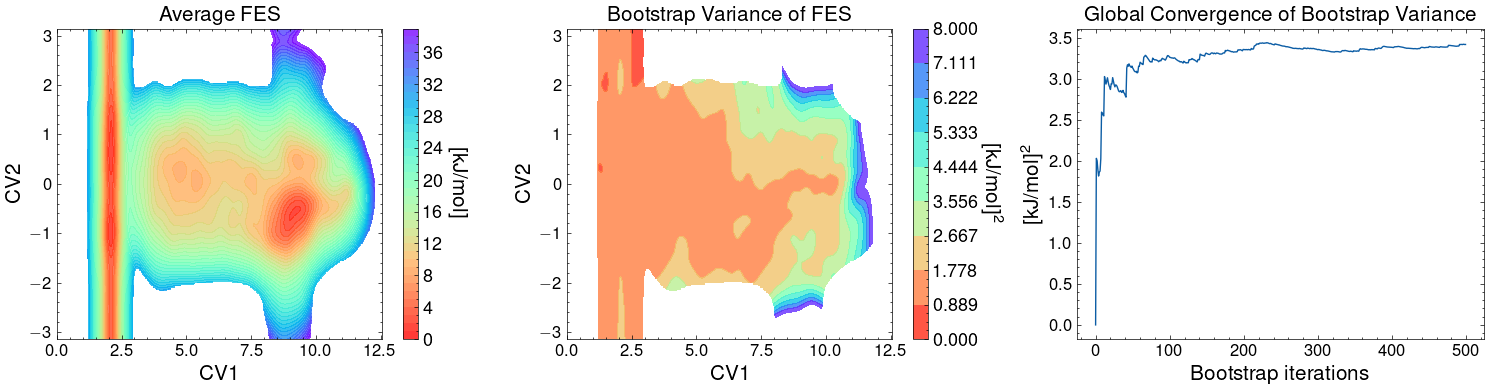

In [11]:
n_simulations = 15

for simulation in np.arange(1,n_simulations+1):

    HILLS=MFI.load_HILLS_2D(hills_name=str(fes_410K_xyl_bckbt_xtb_patch)+"HILLS_"+str(simulation))
    
    #Read the Colvar File
    [position_x, position_y] = MFI.load_position_2D(position_name=str(fes_410K_xyl_bckbt_xtb_patch)+"position_"+str(simulation))
    #COMPUTE Mean force and weight of the simulation
    [X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, time_history, Ftot_den2, ofv_num_x, ofv_num_y] = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw_x = 0.2, bw_y = 0.3, kT = 3.4, min_grid = np.array((0, -np.pi)), max_grid = np.array((4*np.pi, np.pi)), nbins = np.array((200,400)), log_pace = 100, error_pace = 100, base_terms=0, window_corners=[], WellTempered = 0, nhills=-1, periodic_x=0, periodic_y=1, FES_cutoff=40)

    forces_all.append([X, Y, Ftot_den, Ftot_x, Ftot_y])

    master.append([Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_y])

    master_patch.append(MFI.patch_2D(master))
    
    ofe_history_patch += ofe_history
    ofe_history_time_adj = [element+ofe_history_patch_time[-1] for element in time_history]
    ofe_history_patch_time += ofe_history_time_adj
    
    

forces_all_ = np.asarray(forces_all)[:,[2,3,4],:,:]

[FES_avr, sd_fes, sd_fes_prog ] = MFI.bootstrap_2D_new(X, Y, forces_all_, n_bootstrap=500, FES_cutoff=40)

MFI.plot_bootstrap(X, Y, MFI.zero_to_nan(np.where(master_patch[-1][0] > 0.1, FES_avr, 0)), MFI.zero_to_nan(np.where(master_patch[-1][0] > 0.1, sd_fes, 0)), sd_fes_prog, FES_lim=40, ofe_lim=8)
plt.tight_layout()
#plt.show()
plt.savefig("free_energy_surf_xyl_bckbt_410K.png", format="png", dpi=1200)

In [13]:
import json
import codecs

stdtosave = sd_fes.tolist()
sdjson = json.dump(stdtosave, codecs.open(str(fes_410K_xyl_bckbt_xtb_patch)+'std_xyl410.json','w', encoding = 'utf-8'))

fesavgtosave = FES_avr.tolist()
fes_avgjson = json.dump(fesavgtosave, codecs.open(str(fes_410K_xyl_bckbt_xtb_patch)+'fesavg_xyl410.json','w', encoding = 'utf-8'))

In [48]:
f = open(str(fes_410K_xyl_bckbt_xtb_patch)+'fesavg_xyl410.json','r')

Z_matrix_xyl_bckbt_410 = np.array(json.load(f)).reshape(200,400)

var = open(str(fes_410K_xyl_bckbt_xtb_patch)+'std_xyl410.json','r')
variance = json.load(var)

Var_xyl_bckbt_410 = np.array(variance).reshape(200,400)

### 310 K

In [39]:
fes_310K_xyl_bckbt_xtb_patch = 'C:\\Users\\fserse\\Desktop\\PhD_Thesis\\Kinetics from Metadynamics\\Simulation Data\\nButylAcrylate\\BCKBT\\XYL\\310K\\'

forces_all = []
master = []
all_hills= []
error_history = []
Ftot_master = []
master_patch = [[np.zeros((200,400)), np.zeros((200,400)), np.zeros((200,400)), np.zeros((200,400)), np.zeros((200,400)), np.zeros((200,400))]]
FP = np.zeros((200,400))
ofe_history_patch = [0]
ofe_history_patch_time = [0]
X = np.linspace(0, 4*np.pi, 400)
Y = np.linspace(-np.pi, np.pi, 200)

dx = np.abs( X[0] - X[1] )
dy = np.abs( Y[0] - Y[1] )

In [42]:
metadyn2hills(sigma_x,sigma_y,gamma,hartree_2_kj, 1, 13, fes_310K_xyl_bckbt_xtb_patch,90)

|**************************************************| 100% | Bootstrap Average Standard Deviation: 3.075

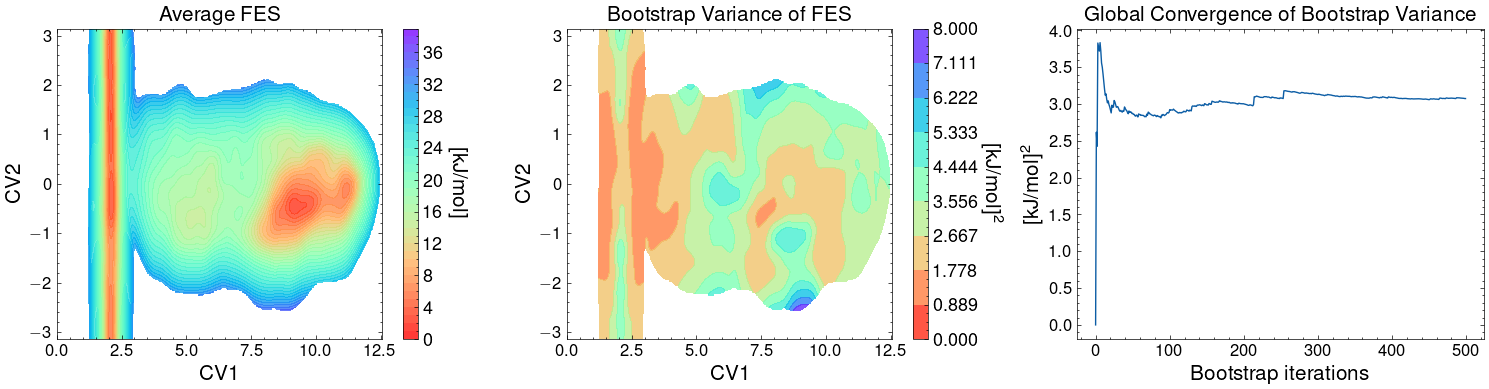

In [43]:
n_simulations = 13

for simulation in np.arange(1,n_simulations+1):

    HILLS=MFI.load_HILLS_2D(hills_name=str(fes_310K_xyl_bckbt_xtb_patch)+"HILLS_"+str(simulation))
    
    #Read the Colvar File
    [position_x, position_y] = MFI.load_position_2D(position_name=str(fes_310K_xyl_bckbt_xtb_patch)+"position_"+str(simulation))
    #COMPUTE Mean force and weight of the simulation
    [X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, time_history, Ftot_den2, ofv_num_x, ofv_num_y] = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw_x = 0.2, bw_y = 0.3, kT = 2.58, min_grid = np.array((0, -np.pi)), max_grid = np.array((4*np.pi, np.pi)), nbins = np.array((200,400)), log_pace = 100, error_pace = 100, base_terms=0, window_corners=[], WellTempered = 0, nhills=-1, periodic_x=0, periodic_y=1, FES_cutoff=40)

    forces_all.append([X, Y, Ftot_den, Ftot_x, Ftot_y])

    master.append([Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_y])

    master_patch.append(MFI.patch_2D(master))
    
    ofe_history_patch += ofe_history
    ofe_history_time_adj = [element+ofe_history_patch_time[-1] for element in time_history]
    ofe_history_patch_time += ofe_history_time_adj
    
    

forces_all_ = np.asarray(forces_all)[:,[2,3,4],:,:]

[FES_avr, sd_fes, sd_fes_prog ] = MFI.bootstrap_2D_new(X, Y, forces_all_, n_bootstrap=500, FES_cutoff=40)

MFI.plot_bootstrap(X, Y, MFI.zero_to_nan(np.where(master_patch[-1][0] > 0.1, FES_avr, 0)), MFI.zero_to_nan(np.where(master_patch[-1][0] > 0.1, sd_fes, 0)), sd_fes_prog, FES_lim=40, ofe_lim=8)
plt.tight_layout()
#plt.show()
plt.savefig("free_energy_surf_xyl_bckbt_310K.png", format="png", dpi=1200)

In [44]:
import json
import codecs

stdtosave = sd_fes.tolist()
sdjson = json.dump(stdtosave, codecs.open(str(fes_310K_xyl_bckbt_xtb_patch)+'std_xyl310.json','w', encoding = 'utf-8'))

fesavgtosave = FES_avr.tolist()
fes_avgjson = json.dump(fesavgtosave, codecs.open(str(fes_310K_xyl_bckbt_xtb_patch)+'fesavg_xyl310.json','w', encoding = 'utf-8'))

In [45]:
f = open(str(fes_310K_xyl_bckbt_xtb_patch)+'fesavg_xyl310.json','r')

Z_matrix_xyl_bckbt_310 = np.array(json.load(f)).reshape(200,400)

var = open(str(fes_310K_xyl_bckbt_xtb_patch)+'std_xyl310.json','r')
variance = json.load(var)

Var_xyl_bckbt_310 = np.array(variance).reshape(200,400)

### Solvent Effect

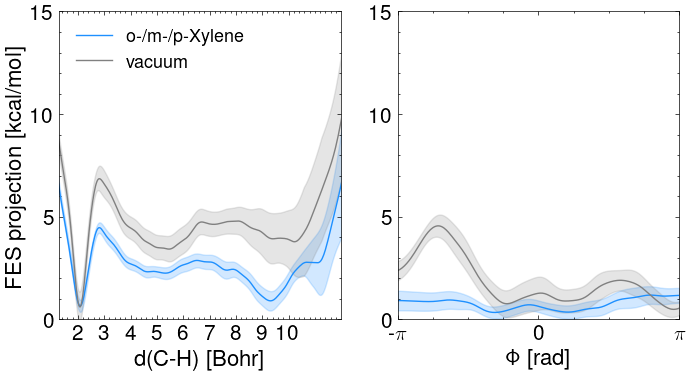

In [22]:
X = np.linspace(0, 4*np.pi, 400)
Y = np.linspace(-np.pi, np.pi, 200)
XX = np.linspace(0, 4*np.pi, 500)
YY = np.linspace(-np.pi, np.pi, 250)

fig, ax = plt.subplots(1,2,figsize=(8, 4))
plt.axis([None, None, 0, None])
#zax = zoomed_inset_axes(ax, 2, loc=1)

ax = plt.subplot(1,2,1)
ax.plot(X,Z_matrix_xyl_bckbt_410[91,:]/4.18,color = "dodgerblue" )
ax.fill_between(X, (Z_matrix_xyl_bckbt_410[91,:] - Var_xyl_bckbt_410[91,:])/4.18, (Z_matrix_xyl_bckbt_410[91,:] + Var_xyl_bckbt_410[91,:])/4.18, alpha=0.2, color = "dodgerblue", label='_nolegend_')
ax.plot(XX,Z_matrix_bckbt_410[101,:]/4.18,color = "gray" )
ax.fill_between(XX, (Z_matrix_bckbt_410[101,:] - Var_bckbt_410[101,:])/4.18, (Z_matrix_bckbt_410[101,:] + Var_bckbt_410[101,:])/4.18, alpha=0.2, color = "gray", label='_nolegend_')
ax.set_ylim([0,15])
ax.set_xlim([1.3,12])
ax.set_xlabel('d(C-H) [Bohr]', fontsize = 16)
ax.set_ylabel('FES projection [kcal/mol]',fontsize = 16)
ax.set_xticks([2,3,4,5,6,7,8,9,10],["2","3","4","5","6","7","8","9","10"] , fontsize=15)
ax.set_yticks([0,5,10,15], ["0", "5", "10","15"], fontsize=15)
ax.legend([ 'o-/m-/p-Xylene', "vacuum" ], fontsize = 13, loc= 'upper left')

ax = plt.subplot(1,2,2)
ax.plot(Y,Z_matrix_xyl_bckbt_410[:,65]/4.18,color = "dodgerblue" )
ax.fill_between(Y, (Z_matrix_xyl_bckbt_410[:,65] - Var_xyl_bckbt_410[:,65])/4.18, (Z_matrix_xyl_bckbt_410[:,65] + Var_xyl_bckbt_410[:,65])/4.18, alpha=0.2, color = "dodgerblue", label='_nolegend_')
ax.plot(YY,Z_matrix_bckbt_410[:,80]/4.18,color = "gray" )
ax.fill_between(YY, (Z_matrix_bckbt_410[:,80] - Var_bckbt_410[:,80])/4.18, (Z_matrix_bckbt_410[:,80] + Var_bckbt_410[:,80])/4.18, alpha=0.2, color = "gray", label='_nolegend_')
ax.set_ylim([0,15])
ax.set_xlim([-np.pi,np.pi])
ax.set_xlabel(' $ \Phi $ [rad]', fontsize = 16)
#ax.set_ylabel('FES projection [kcal/mol]',fontsize = 13)
ax.set_xticks([-np.pi,0,np.pi], ["-$ \pi $", "0", "$ \pi $"], fontsize=15)
ax.set_yticks([0,5,10, 15], ["0", "5", "10", "15"], fontsize=15)
#ax.legend([ 'vacuum', "nBA monomer" ], fontsize = 13)
plt.savefig("free_energy_profiles_ba_bckbt.png", format="png", dpi=1200)

### Temperature Effect

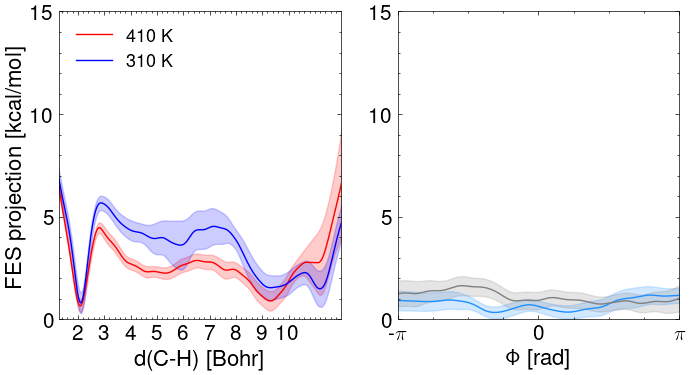

In [61]:
X = np.linspace(0, 4*np.pi, 400)
Y = np.linspace(-np.pi, np.pi, 200)

fig, ax = plt.subplots(1,2,figsize=(8, 4))
plt.axis([None, None, 0, None])
#zax = zoomed_inset_axes(ax, 2, loc=1)

ax = plt.subplot(1,2,1)
ax.plot(X,Z_matrix_xyl_bckbt_410[91,:]/4.18,color = "red" )
ax.fill_between(X, (Z_matrix_xyl_bckbt_410[91,:] - Var_xyl_bckbt_410[91,:])/4.18, (Z_matrix_xyl_bckbt_410[91,:] + Var_xyl_bckbt_410[91,:])/4.18, alpha=0.2, color = "red", label='_nolegend_')
ax.plot(X,Z_matrix_xyl_bckbt_310[101,:]/4.18,color = "blue" )
ax.fill_between(X, (Z_matrix_xyl_bckbt_310[101,:] - Var_xyl_bckbt_310[101,:])/4.18, (Z_matrix_xyl_bckbt_310[101,:] + Var_xyl_bckbt_310[101,:])/4.18, alpha=0.2, color = "blue", label='_nolegend_')
ax.set_ylim([0,15])
ax.set_xlim([1.3,12])
ax.set_xlabel('d(C-H) [Bohr]', fontsize = 16)
ax.set_ylabel('FES projection [kcal/mol]',fontsize = 16)
ax.set_xticks([2,3,4,5,6,7,8,9,10],["2","3","4","5","6","7","8","9","10"] , fontsize=15)
ax.set_yticks([0,5,10,15], ["0", "5", "10","15"], fontsize=15)
ax.legend([ '410 K', "310 K" ], fontsize = 13, loc= 'upper left')

ax = plt.subplot(1,2,2)
ax.plot(Y,Z_matrix_xyl_bckbt_410[:,65]/4.18,color = "dodgerblue" )
ax.fill_between(Y, (Z_matrix_xyl_bckbt_410[:,65] - Var_xyl_bckbt_410[:,65])/4.18, (Z_matrix_xyl_bckbt_410[:,65] + Var_xyl_bckbt_410[:,65])/4.18, alpha=0.2, color = "dodgerblue", label='_nolegend_')
ax.plot(Y,Z_matrix_xyl_bckbt_310[:,65]/4.18,color = "gray" )
ax.fill_between(Y, (Z_matrix_xyl_bckbt_310[:,65] - Var_xyl_bckbt_310[:,80])/4.18, (Z_matrix_xyl_bckbt_310[:,65] + Var_xyl_bckbt_310[:,80])/4.18, alpha=0.2, color = "gray", label='_nolegend_')
ax.set_ylim([0,15])
ax.set_xlim([-np.pi,np.pi])
ax.set_xlabel(' $ \Phi $ [rad]', fontsize = 16)
#ax.set_ylabel('FES projection [kcal/mol]',fontsize = 13)
ax.set_xticks([-np.pi,0,np.pi], ["-$ \pi $", "0", "$ \pi $"], fontsize=15)
ax.set_yticks([0,5,10, 15], ["0", "5", "10", "15"], fontsize=15)
#ax.legend([ 'vacuum', "nBA monomer" ], fontsize = 13)
plt.savefig("free_energy_profiles_xyl_bckbt.png", format="png", dpi=1200)

In [50]:
import plotly.graph_objects as go
fig = go.Figure(data=[go.Surface(x=X,y=Y,z=Z_matrix_xyl_bckbt_310/4.18, colorscale = 'YlGnBu_r')])

fig.show()

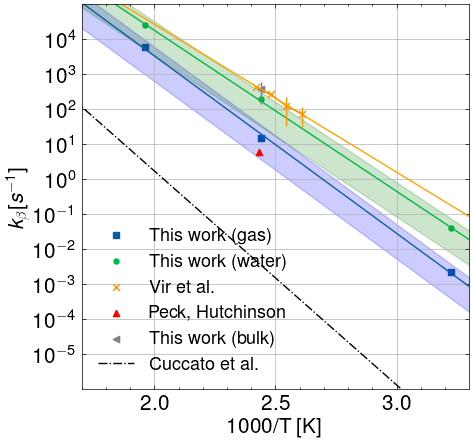

In [13]:
from sklearn.linear_model import LinearRegression

plt.figure(figsize=(5,5))

kb = 1.38*1e-23
h = 6.626*1e-34

inv_temp = np.linspace(1000/600,1000/300,1000).reshape((-1,1))

# corrected
k_310 = 3.6*1e+12*np.exp(-(29700-8130)/1.987/310)
k_410 = 3.8*1e+12*np.exp(-(29500-8130)/1.987/410)
k_510 = 4.0*1e+12*np.exp(-(28700-8130)/1.987/510)

deltaK_310 = 3.6*1e+12/1.987/310*np.exp(-(29700-8130)/1.987/310)*500
deltaK_410 = 3.8*1e+12/1.987/410*np.exp(-(29500-8130)/1.987/410)*500
deltaK_510 = 4.0*1e+12/1.987/510*np.exp(-(28700-8130)/1.987/510)*500

kappas = np.array([k_310,k_410,k_510]).reshape((-1,1))
kappas_error_gas = np.array([deltaK_310,deltaK_410,deltaK_510]).reshape((-1,1))
                                        
k_xyl_310 = 4.0*1e+12*np.exp(-(28000-8130)/1.987/310)
k_xyl_410 = 4.2*1e+12*np.exp(-(27500-8130)/1.987/410)
k_xyl_510 = 4.5*1e+12*np.exp(-(27400-8130)/1.987/510)

k_bulk_410 = 4.2*1e+12*np.exp(-(27000-8130)/1.987/410) 
deltak_bulk_410 = 4.2*1e+12/1.987/410*np.exp(-(27000-8130)/1.987/410)*500

deltaK_xyl_310 = 4.0*1e+12/1.987/310*np.exp(-(28000-8130)/1.987/310)*500
deltaK_xyl_410 = 4.2*1e+12/1.987/410*np.exp(-(27500-8130)/1.987/410)*500
deltaK_xyl_510 = 4.5*1e+12/1.987/510*np.exp(-(27400-8130)/1.987/510)*500

relative_err_xyl = deltaK_xyl_310/k_xyl_310
k_xyl = np.array([k_xyl_310,k_xyl_410,k_xyl_510]).reshape((-1,1))
kappas_error_wat = np.array([deltaK_xyl_310,deltaK_xyl_410,deltaK_xyl_510]).reshape((-1,1))                                
InvT_marien = [2.420253165,2.480168776,2.543881857,2.610126582]
k_marien = [435.4026288,267.4634846,125.2746434,71.91060345]
k_vir = np.array([435.4026288,267.4634846,125.2746434,71.91060345]).reshape((-1,1))
k_cucc = 10**(12.460)*np.exp(-(116900/4.18/1000)/1.987*inv_temp)

InvT = np.array([1000/310,1000/410,1000/510]).reshape((-1,1))

line = LinearRegression().fit(InvT,np.log(kappas))
Ea = line.coef_
k0 = line.intercept_
Ea = Ea[0].round(2)

linew = LinearRegression().fit(InvT,np.log(k_xyl))
Eaw = linew.coef_
k0w = linew.intercept_
Eaw = Eaw[0].round(2)

linev = LinearRegression().fit(np.array(InvT_marien).reshape((-1,1)),np.log(k_vir))
Eav = linev.coef_
k0v = linev.intercept_
Eav = Eav[0].round(2)
k_vir = np.exp(k0v)*np.exp(Eav*inv_temp)
k_wat = np.exp(k0w)*np.exp(Eaw*inv_temp)

plt.scatter(InvT,kappas,s=13, marker="s", label="This work (gas)")
k_mod = np.exp(k0)*np.exp(Ea*inv_temp)
plt.plot(inv_temp,k_mod, label="_")
plt.fill_between(inv_temp.reshape(-1),(k_mod-k_mod*relative_err_xyl).reshape(-1),(k_mod+k_mod*relative_err_xyl).reshape(-1), alpha=0.2, color='b', label='_nolegend_')
plt.scatter(InvT,k_xyl,s=13, label="This work (water)")
plt.plot(inv_temp,k_wat, label="_")
plt.fill_between(inv_temp.reshape(-1),(k_wat-k_wat*relative_err_xyl).reshape(-1),(k_wat+k_wat*relative_err_xyl).reshape(-1), alpha=0.2, color='g', label='_nolegend_')
plt.errorbar(InvT_marien, k_marien, yerr=[9.7,20.7,91.2,41.2])
plt.scatter(InvT_marien,k_marien,s=25, marker="x", label="Vir et al.")
plt.plot(inv_temp,k_vir, label="_", color="#FFA500")


plt.scatter(1000/411,6,s=20, marker="^", color='r', label="Peck, Hutchinson")
plt.errorbar(1000/410, k_bulk_410, yerr=deltak_bulk_410, color='gray')
plt.scatter(1000/410,k_bulk_410,s=20, marker="<", color='gray', label="This work (bulk)")

plt.plot(inv_temp,k_cucc,linestyle='dashdot', label="Cuccato et al.", color='k')
plt.yscale('log')
plt.xlim(1.7,3.3)
plt.ylim(1e-6,100000)
plt.xlabel("1000/T [K]", fontsize=15), plt.ylabel(r'$k_{\beta} [s^{-1}]$', fontsize=15); 
plt.xticks([2,2.5,3],["2.0", "2.5", "3.0"] , fontsize=15)
plt.yticks([1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e+2,1e+3,1e+4],["10$^{-5}$", "10$^{-4}$", "10$^{-3}$", "10$^{-2}$", "10$^{-1}$", "10$^{0}$", "10$^{1}$", "10$^{2}$", "10$^{3}$", "10$^{4}$"] ,fontsize=15)
plt.legend(fontsize=13)
plt.grid(visible=True,which='major')
#plt.savefig("rates.png", format="png", dpi=1200)


## Entropy and Enthalpy surfaces

**Backbiting**

I) Reference Entropic and Enthalpic maps in CVs space estimated by taking the difference in free energy at two different temperatures, 310K and 410 K.

In [63]:
DS = (Z_matrix_bckbt_410 - Z_matrix_bckbt_310)/(410-310)
DH = Z_matrix_bckbt_410 + DS*410
TDS = 410*DS

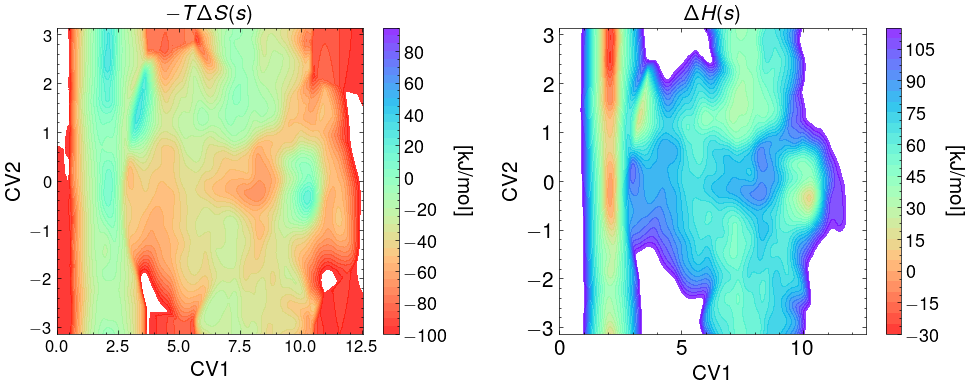

In [83]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
cp = axs[0].contourf(X, Y, -TDS, levels=range(-100, 100, 5), cmap='rainbow_r', antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[0])
cbar.ax.tick_params(labelsize=13)
cbar.set_label("[kJ/mol]", rotation=270,labelpad=17, fontsize=15)
axs[0].set_ylabel('CV2', fontsize=15)
axs[0].set_xlabel('CV1', fontsize=15)
axs[0].set_title('$-T \Delta S(s)$', fontsize=15)
axs[0].tick_params(axis='both', which='major', labelsize=12)
axs[0].set_box_aspect(1)

cp = axs[1].contourf(X, Y, DH, levels=range(-30,120 ,5), cmap='rainbow_r', antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[1])
cbar.set_label("[kJ/mol]", rotation=270,labelpad=17, fontsize=15)
cbar.ax.tick_params(labelsize=13)
axs[1].set_ylabel('CV2', fontsize=15)
axs[1].set_xlabel('CV1', fontsize=15)
axs[1].set_title('$\Delta H(s)$', fontsize=15)
axs[1].tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
axs[1].set_box_aspect(1)
plt.savefig("enthaply_entropy_surf_xyl_bckbt_410K.png", format="png", dpi=1200)

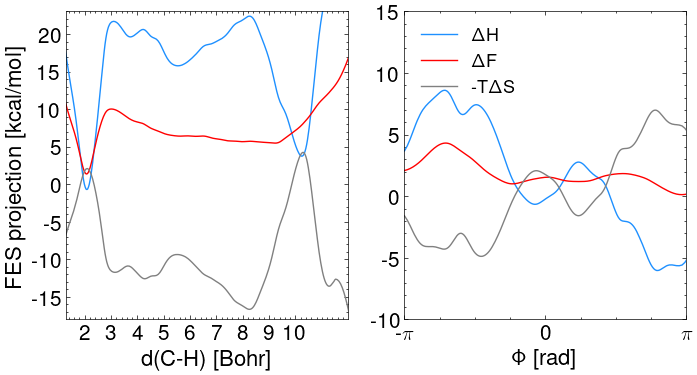

In [82]:
fig, ax = plt.subplots(1,2,figsize=(8, 4))
plt.axis([None, None, 0, None])
#zax = zoomed_inset_axes(ax, 2, loc=1)

ax = plt.subplot(1,2,1)
ax.plot(X,DH[91,:]/4.18,color = "dodgerblue" )
ax.plot(X,Z_matrix_bckbt_410[91,:]/4.18,color = "r" )
#ax.plot(X,(DH-TDS)[91,:]/4.18,color = "r",linestyle="dashed" )
#ax.fill_between(X, (DH[91,:])/4.18, (DH[91,:])/4.18, alpha=0.2, color = "dodgerblue", label='_nolegend_')
ax.plot(X,-TDS[91,:]/4.18,color = "gray" )
#ax.fill_between(X, (-TDS[91,:])/4.18, (-TDS[91,:])/4.18, alpha=0.2, color = "gray", label='_nolegend_')
ax.set_ylim([-18,23])
ax.set_xlim([1.3,12])
ax.set_xlabel('d(C-H) [Bohr]', fontsize = 16)
ax.set_ylabel('FES projection [kcal/mol]',fontsize = 16)
ax.set_xticks([2,3,4,5,6,7,8,9,10],["2","3","4","5","6","7","8","9","10"] , fontsize=15)
ax.set_yticks([-15,-10,-5,0,5,10,15,20], ["-15","-10","-5","0", "5", "10","15","20"], fontsize=15)
#ax.legend([ 'DH', "DF","-TDS" ], fontsize = 13, loc= 'upper left')

ax = plt.subplot(1,2,2)
ax.plot(Y,DH[:,65]/4.18,color = "dodgerblue" )
ax.plot(Y,Z_matrix_bckbt_410[:,65]/4.18,color = "r" )
#ax.fill_between(Y, (DH[:,65])/4.18, (DH[:,65])/4.18, alpha=0.2, color = "dodgerblue", label='_nolegend_')
ax.plot(Y,-TDS[:,65]/4.18,color = "gray" )
#ax.fill_between(Y, (-TDS[:,65] - Var_bckbt_410[:,65])/4.18, (Z_matrix_bckbt_410[:,65] + Var_bckbt_410[:,65])/4.18, alpha=0.2, color = "gray", label='_nolegend_')
ax.set_ylim([-10,15])
ax.set_xlim([-np.pi,np.pi])
ax.set_xlabel(' $ \Phi $ [rad]', fontsize = 16)
#ax.set_ylabel('FES projection [kcal/mol]',fontsize = 13)
ax.set_xticks([-np.pi,0,np.pi], ["-$ \pi $", "0", "$ \pi $"], fontsize=15)
ax.set_yticks([-10,-5,0,5,10, 15], ["-10","-5","0", "5", "10", "15"], fontsize=15)
ax.legend([ '$\Delta$H', "$\Delta$F","-T$\Delta$S" ], fontsize = 13, loc= 'upper left')
plt.savefig("enthalpy_entropy_profiles_ba_bckbt.png", format="png", dpi=1200)

II) Calculate Entropic an Enthalpic maps from a single simulation

In [ ]:
fig = go.Figure(data=[go.Surface(x=X,y=Y,z=DH, colorscale = 'YlGnBu_r')])

fig.show()

#### Entropic and Enthalpic contributions in the presence of Solvent

In [54]:
DS = (Z_matrix_xyl_bckbt_410 - Z_matrix_xyl_bckbt_310)/(410-310)
DH = Z_matrix_xyl_bckbt_410 + DS*410
TDS = 410*DS

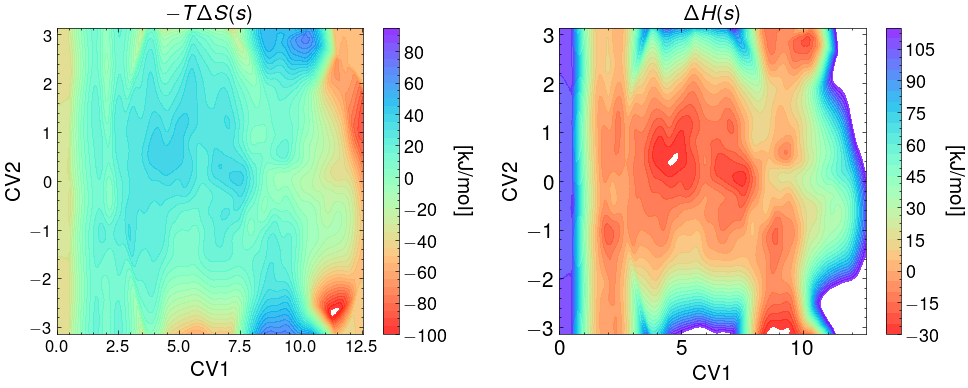

In [55]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
cp = axs[0].contourf(X, Y, -TDS, levels=range(-100, 100, 5), cmap='rainbow_r', antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[0])
cbar.ax.tick_params(labelsize=13)
cbar.set_label("[kJ/mol]", rotation=270,labelpad=17, fontsize=15)
axs[0].set_ylabel('CV2', fontsize=15)
axs[0].set_xlabel('CV1', fontsize=15)
axs[0].set_title('$-T \Delta S(s)$', fontsize=15)
axs[0].tick_params(axis='both', which='major', labelsize=12)
axs[0].set_box_aspect(1)

cp = axs[1].contourf(X, Y, DH, levels=range(-30,120 ,5), cmap='rainbow_r', antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[1])
cbar.set_label("[kJ/mol]", rotation=270,labelpad=17, fontsize=15)
cbar.ax.tick_params(labelsize=13)
axs[1].set_ylabel('CV2', fontsize=15)
axs[1].set_xlabel('CV1', fontsize=15)
axs[1].set_title('$\Delta H(s)$', fontsize=15)
axs[1].tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
axs[1].set_box_aspect(1)
plt.savefig("enthaply_entropy_surf_xyl_bckbt_410K.png", format="png", dpi=1200)

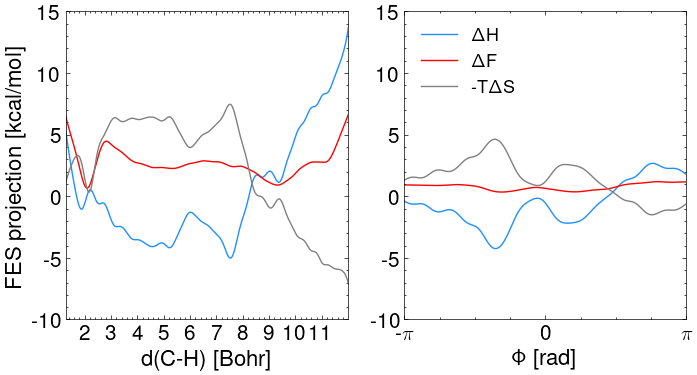

In [63]:
fig, ax = plt.subplots(1,2,figsize=(8, 4))
plt.axis([None, None, 0, None])
#zax = zoomed_inset_axes(ax, 2, loc=1)

ax = plt.subplot(1,2,1)
ax.plot(X,DH[91,:]/4.18,color = "dodgerblue" )
ax.plot(X,Z_matrix_xyl_bckbt_410[91,:]/4.18,color = "r" )
#ax.plot(X,(DH-TDS)[91,:]/4.18,color = "r",linestyle="dashed" )
#ax.fill_between(X, (DH[91,:])/4.18, (DH[91,:])/4.18, alpha=0.2, color = "dodgerblue", label='_nolegend_')
ax.plot(X,-TDS[91,:]/4.18,color = "gray" )
#ax.fill_between(X, (-TDS[91,:])/4.18, (-TDS[91,:])/4.18, alpha=0.2, color = "gray", label='_nolegend_')
ax.set_ylim([-10,15])
ax.set_xlim([1.3,12])
ax.set_xlabel('d(C-H) [Bohr]', fontsize = 16)
ax.set_ylabel('FES projection [kcal/mol]',fontsize = 16)
ax.set_xticks([2,3,4,5,6,7,8,9,10,11],["2","3","4","5","6","7","8","9","10","11"] , fontsize=15)
ax.set_yticks([-10,-5,0,5,10,15], ["-10","-5","0", "5", "10","15"], fontsize=15)
#ax.legend([ 'DH', "DF","-TDS" ], fontsize = 13, loc= 'upper left')

ax = plt.subplot(1,2,2)
ax.plot(Y,DH[:,65]/4.18,color = "dodgerblue" )
ax.plot(Y,Z_matrix_xyl_bckbt_410[:,65]/4.18,color = "r" )
#ax.fill_between(Y, (DH[:,65])/4.18, (DH[:,65])/4.18, alpha=0.2, color = "dodgerblue", label='_nolegend_')
ax.plot(Y,-TDS[:,65]/4.18,color = "gray" )
#ax.fill_between(Y, (-TDS[:,65] - Var_bckbt_410[:,65])/4.18, (Z_matrix_bckbt_410[:,65] + Var_bckbt_410[:,65])/4.18, alpha=0.2, color = "gray", label='_nolegend_')
ax.set_ylim([-10,15])
ax.set_xlim([-np.pi,np.pi])
ax.set_xlabel(' $ \Phi $ [rad]', fontsize = 16)
#ax.set_ylabel('FES projection [kcal/mol]',fontsize = 13)
ax.set_xticks([-np.pi,0,np.pi], ["-$ \pi $", "0", "$ \pi $"], fontsize=15)
ax.set_yticks([-10,-5,0,5,10, 15], ["-10","-5","0", "5", "10", "15"], fontsize=15)
ax.legend([ '$\Delta$H', "$\Delta$F","-T$\Delta$S" ], fontsize = 13, loc= 'upper left')
plt.savefig("enthalpy_entropy_profiles_ba_bckbt.png", format="png", dpi=1200)

### Minimum Free Energy Pathway